In [1]:
# How do similar networks respond to FGSM Attacks from foolbox?
# Classic vs FGN vs Converted+trained

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 5.0)

In [4]:
import numpy as np

from foolbox import PyTorchModel, accuracy
import foolbox.attacks as fa
import foolbox as fb

import torch
from torch import optim

import copy

In [5]:
# custom library imports
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [6]:
# check gpus
!gpustat

crescent                Mon Mar  1 21:33:48 2021  418.152.00
[0] GeForce RTX 2080 Ti | 28'C,   0 % |  4836 / 10989 MB | near(1305M) salami(907M) salami(909M) salami(853M) salami(851M)
[1] GeForce RTX 2080 Ti | 27'C,   0 % |    11 / 10989 MB |


In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
# torch.cuda.set_device(0)

CUDA Available:  False
Using device: cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
# get data 
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=10000, 
                                                                                   batch_size_for_val=100000)

# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000

images, labels = mnist_val_loader.dataset.tensors
images = images.to(device)
labels = labels.to(device)

In [9]:
# load classic model
classic_model_path = "../Experiments/sample_models/sample_classic_full.pth"
classic_model = torch.load(classic_model_path, map_location=torch.device(device))
# classic_model.to(device)

In [10]:
# classic model params
!cat '../Experiments/sample_models/sample_FGN_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
ordinal 2.0
covar_type sphere
lambda for l2 loss 8e-06
lambda for sigma loss 1e-06
non-linearity True


In [11]:
# load an fgn model check same params as FGN
fgn_model_path = '../Experiments/sample_models/sample_FGN_full.pth'
fgn_model = torch.load(fgn_model_path, map_location=torch.device(device))
# fgn_model.to(device)

In [12]:
# convert model
fgnl.convert_classic_to_fgn(classic_model, fgn_model, init_factor=1e1, verbose=True)

odict_keys([])

Classic odict_keys(['hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weight', 'hidden_layers.4.bias', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_layers.5.running_mean', 'hidden_layers.5.running_var', 'hidden_layers.5.num_batches_tracked', 'ib.weight', 'ib.bias', 'ib.running_mean', 'ib.running_var', 'ib.num_batches_tracked', 'fl.weight', 'fl.bias'])
FGN odict_keys(['hidden_layers.1.weights', 'hidden_layers.1.biases', 'hidden_layers.1.centers', 'hidden_layers.1.inv_covars', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weights', 'hidden_layers.4.biases', 'hidden_layers.4.centers', 'hidden_layers.4.inv_covars', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_la

In [13]:
# do a quick retrain of the converted model
ret_quick_fgn_model = copy.deepcopy(fgn_model)
# ret_quick_fgn_model.to(device)

# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e-5
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, ret_quick_fgn_model.parameters()), lr=1e-3)

# train the network for N epochs
epochs = 1
train_res = fgnh.train(ret_quick_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 1e-05
Epoch 0 Train set - Average loss: 1.5079, Accuracy: 48353/50000 (97%)
Test set - Average loss: 0.4366, Accuracy: 9746/10000 (97%)


In [14]:
# # load heavily retrained model
# ret_fgn_model_path = '../Experiments/sample_models/sample_fgn_converted+retrained_full.pth'
# ret_fgn_model = torch.load(ret_fgn_model_path)
# ret_fgn_model.to(device)

In [15]:
# do a long retrain of the converted model
ret_fgn_model= copy.deepcopy(fgn_model)

# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e-1
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, ret_fgn_model.parameters()), lr=1e-3)

# train the network for N epochs
epochs = 75
train_res = fgnh.train(ret_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 1e-05
Epoch 0 Train set - Average loss: 1.5088, Accuracy: 48437/50000 (97%)
Test set - Average loss: 0.4355, Accuracy: 9749/10000 (97%)
Epoch 1 Train set - Average loss: 0.3625, Accuracy: 48486/50000 (97%)
Test set - Average loss: 0.2743, Accuracy: 9749/10000 (97%)
Epoch 2 Train set - Average loss: 0.2617, Accuracy: 48442/50000 (97%)
Test set - Average loss: 0.2241, Accuracy: 9747/10000 (97%)
Epoch 3 Train set - Average loss: 0.2226, Accuracy: 48456/50000 (97%)
Test set - Average loss: 0.2008, Accuracy: 9746/10000 (97%)
Epoch 4 Train set - Average loss: 0.2026, Accuracy: 48550/50000 (97%)
Test set - Average loss: 0.1879, Accuracy: 9749/10000 (97%)
Epoch 5 Train set - Average loss: 0.1946, Accuracy: 48459/50000 (97%)
Test set - Average loss: 0.1801, Accuracy: 9747/10000 (97%)
Epoch 6 Train set - Average loss: 0.1855, Accuracy: 48511/50000 (97%)
Test set - Average loss: 0.1752, Accuracy: 9750/10000 (98%)
Epoch 7 Train set - Average loss: 0.

Test set - Average loss: 0.1245, Accuracy: 9770/10000 (98%)
Epoch 63 Train set - Average loss: 0.1180, Accuracy: 48684/50000 (97%)
Test set - Average loss: 0.1241, Accuracy: 9768/10000 (98%)
Epoch 64 Train set - Average loss: 0.1155, Accuracy: 48752/50000 (98%)
Test set - Average loss: 0.1237, Accuracy: 9767/10000 (98%)
Epoch 65 Train set - Average loss: 0.1167, Accuracy: 48686/50000 (97%)
Test set - Average loss: 0.1227, Accuracy: 9765/10000 (98%)
Epoch 66 Train set - Average loss: 0.1147, Accuracy: 48715/50000 (97%)
Test set - Average loss: 0.1222, Accuracy: 9769/10000 (98%)
Epoch 67 Train set - Average loss: 0.1180, Accuracy: 48674/50000 (97%)
Test set - Average loss: 0.1221, Accuracy: 9767/10000 (98%)
Epoch 68 Train set - Average loss: 0.1143, Accuracy: 48741/50000 (97%)
Test set - Average loss: 0.1217, Accuracy: 9766/10000 (98%)
Epoch 69 Train set - Average loss: 0.1148, Accuracy: 48711/50000 (97%)
Test set - Average loss: 0.1213, Accuracy: 9764/10000 (98%)
Epoch 70 Train set - Av

In [16]:
# set model bounds and preprocessing

# bounds - I think these might be the bounds:
# inputs ? I think it this
# noise?
# bounds = (-(max_pix-min_pix)/128,(max_pix-min_pix)/128)
bounds = (min_pix+1e-6, max_pix-1e-6)
# preprocessing - I think these would be used in similar way to pytorch preprocessing
# but possible passed to whatever architecture is used (torch, tensorflow, other) 
# in my case the dataloaders already normalizes the data
preprocessing = dict(mean=0, std=1)

In [17]:
# ready the models for foolbox
classic_model.eval()
classic_f_model = PyTorchModel(classic_model, bounds=bounds, device=device)

fgn_model.eval()
fgn_f_model = PyTorchModel(fgn_model, bounds=bounds, device=device)

ret_quick_fgn_model.eval()
ret_quick_fgn_f_model = PyTorchModel(ret_quick_fgn_model, bounds=bounds, device=device)

ret_fgn_model.eval()
ret_fgn_f_model = PyTorchModel(ret_fgn_model, bounds=bounds, device=device)

In [18]:
ret_fgn_f_model.bounds

Bounds(lower=-0.42421196238899234, upper=2.821485711502075)

In [19]:
# check model accuracies
print('accuracies for classic and fgn models')
print(accuracy(classic_f_model, images, labels))
print(accuracy(fgn_f_model, images, labels))
print(accuracy(ret_quick_fgn_f_model, images, labels))
print(accuracy(ret_fgn_f_model, images, labels))

accuracies for classic and fgn models
0.9739000201225281
0.973800003528595
0.9746000170707703
0.9776999950408936


In [20]:
# attack params to explore
epsilons = [(max_pix-min_pix)*x 
            for x in 
            [0.0,
             1/256,
             3/512,
             1/128,
             3/256,
             1/64,
             3/128,
             1/32,
             3/64,
             1/16,
             3/32,
             1/8,
             3/16,
             1/4,
             3/8,
             1/2,
             3/4,
             1.0,] ]

print('epsilons: {}'.format(epsilons))

epsilons: [0.0, 0.012678514351136982, 0.019017771526705474, 0.025357028702273965, 0.03803554305341095, 0.05071405740454793, 0.0760710861068219, 0.10142811480909586, 0.1521421722136438, 0.20285622961819172, 0.3042843444272876, 0.40571245923638344, 0.6085686888545752, 0.8114249184727669, 1.2171373777091503, 1.6228498369455338, 2.4342747554183006, 3.2456996738910675]


In [21]:
# attack the classic model
classic_raw, classic_clipped, classic_adv_success = fa.FGSM()(classic_f_model, images, labels, epsilons=epsilons)

In [22]:
# attack the converted fgn model
fgn_raw, fgn_clipped, fgn_adv_success = fa.FGSM()(fgn_f_model, images, labels, epsilons=epsilons)

In [23]:
# attack the quick retrained fgn model
ret_quick_fgn_raw, ret_quick_fgn_clipped, ret_quick_fgn_adv_success = fa.FGSM()(ret_quick_fgn_f_model, images, labels, epsilons=epsilons)

In [24]:
# attack the  long retrained fgn model
ret_fgn_raw, ret_fgn_clipped, ret_fgn_adv_success = fa.FGSM()(ret_fgn_f_model, images, labels, epsilons=epsilons)

In [25]:
names = ['Classic', 'converted FGN', 'quick retrain FGN', 'long retrain FGN']

Classic Accuracy per epsilon [0.9739 0.1838 0.1343 0.1103 0.0873 0.0783 0.0717 0.0674 0.0648 0.0633
 0.0623 0.0614 0.0615 0.0609 0.0605 0.0604 0.0605 0.0605]
FGN Accuracy per epsilon [0.9738 0.1835 0.134  0.1096 0.087  0.0781 0.0708 0.0663 0.06   0.0736
 0.0803 0.0939 0.0756 0.0967 0.0967 0.0967 0.0967 0.1135]
Quick Retrained FGN Accuracy per epsilon [0.9746 0.1864 0.1332 0.111  0.0859 0.0755 0.0953 0.0922 0.1028 0.092
 0.0967 0.0967 0.0967 0.0967 0.0992 0.0991 0.0991 0.0991]
Long Retrained FGN Accuracy per epsilon [0.9777 0.237  0.1919 0.187  0.1445 0.1151 0.1125 0.0965 0.0967 0.0967
 0.0967 0.0967 0.0967 0.1001 0.0991 0.0991 0.0991 0.0991]


<IPython.core.display.Javascript object>


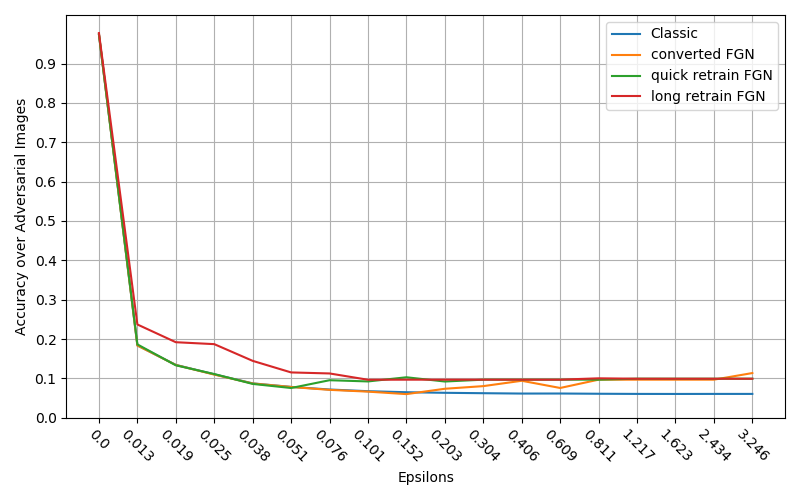

In [26]:
# compare raw success rates
print('Classic Accuracy per epsilon', 1.0 - classic_adv_success.cpu().numpy().mean(axis=-1))
print('FGN Accuracy per epsilon', 1.0 - fgn_adv_success.cpu().numpy().mean(axis=-1))
print('Quick Retrained FGN Accuracy per epsilon', 1.0 - ret_quick_fgn_adv_success.cpu().numpy().mean(axis=-1))
print('Long Retrained FGN Accuracy per epsilon', 1.0 - ret_fgn_adv_success.cpu().numpy().mean(axis=-1))

plt.plot(1.0 - classic_adv_success.cpu().numpy().mean(axis=-1), label=names[0])
plt.plot(1.0 - fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[1])
plt.plot(1.0 - ret_quick_fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[2])
plt.plot(1.0 - ret_fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[3])
plt.legend()
plt.xticks(range(len(epsilons)), labels=np.round(epsilons,3), rotation=-45)
plt.xlabel('Epsilons')
plt.yticks([x/100 for x in range(0,100,10)])
plt.ylabel('Accuracy over Adversarial Images')
plt.tight_layout()
plt.grid()
plt.show()

In [27]:
# extract succesful adv indices
classic_successful_adv_indices = [np.flatnonzero(x) for x in classic_adv_success.cpu().numpy()]
fgn_successful_adv_indices = [np.flatnonzero(x) for x in fgn_adv_success.cpu().numpy()]
ret_quick_fgn_successful_adv_indices = [np.flatnonzero(x) for x in ret_quick_fgn_adv_success.cpu().numpy()]
ret_fgn_successful_adv_indices = [np.flatnonzero(x) for x in ret_fgn_adv_success.cpu().numpy()]

In [28]:
# extract succesful adv raw images
classic_raw_successful = [torch.stack([classic_raw[i][k] for k in j]) 
                          for i,j in enumerate(classic_successful_adv_indices)]
fgn_raw_successful = [torch.stack([fgn_raw[i][k] for k in j])
                      for i,j in enumerate(fgn_successful_adv_indices)]
ret_quick_fgn_raw_successful = [torch.stack([ret_quick_fgn_raw[i][k] for k in j])
                      for i,j in enumerate(ret_quick_fgn_successful_adv_indices)]
ret_fgn_raw_successful = [torch.stack([ret_fgn_raw[i][k] for k in j])
                      for i,j in enumerate(ret_fgn_successful_adv_indices)]

In [29]:
# per epsilon, number of attacks that both:
#  - change the class
#  - have over 0.5 confidence

per_epsilon = []

for i, clipped_images in enumerate(zip(classic_raw_successful, fgn_raw_successful, 
                                       ret_quick_fgn_raw_successful, ret_fgn_raw_successful)):
    
    per_model = [] 
    for n, model in enumerate([classic_model, fgn_model, ret_quick_fgn_model, ret_fgn_model]):
        
        # compute predictions
        model.eval()
        with torch.no_grad(): preds = model(clipped_images[n].to(device))
        preds = preds.cpu().detach().numpy()
        
        # apply softmax for probabilities
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])
        # get the maximums
        preds_maxes = np.max(preds_softmax, axis=1)
        
        per_model.append(len([x for x in preds_maxes if x>=0.5 ]))
    per_epsilon.append(per_model)

In [30]:
l = list(zip(*per_epsilon))

In [31]:
np.reshape(l, (3,-1))

array([[ 242, 7460, 7929, 8242, 8585, 8727, 8813, 8845, 8878, 8897, 8880,
        8890, 8903, 8915, 8925, 8928, 8932, 8935,  241, 7443, 7902, 8202,
        8531, 8670],
       [8587, 8462, 7223,  389,    1,    0,    0,    0,    0,    0,    0,
           0,  223, 7222, 7608, 7733, 7343, 5229,   20,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,  200, 6612, 6180, 3480, 1119,
          48,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])

<IPython.core.display.Javascript object>


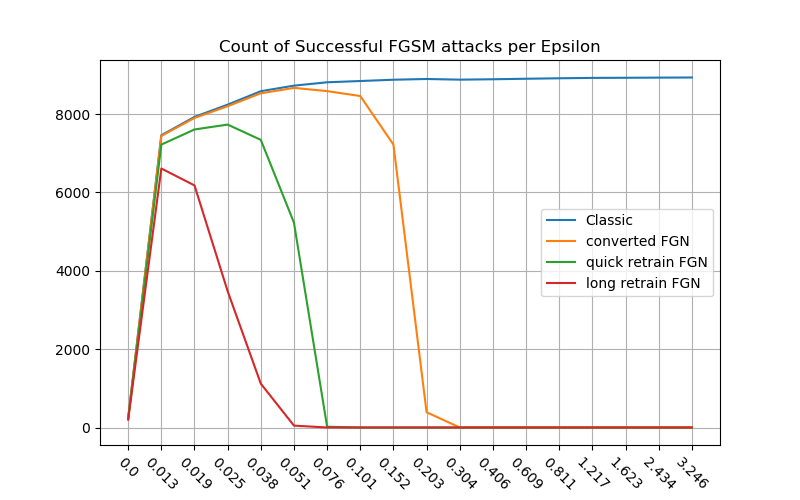

In [32]:
for n, p in enumerate(l):
    plt.plot(p, label=names[n])

plt.legend()
plt.grid()
plt.title('Count of Successful FGSM attacks per Epsilon')
plt.xticks(range(len(epsilons)), labels=np.round(epsilons,3), rotation=-45)
plt.show()

<IPython.core.display.Javascript object>


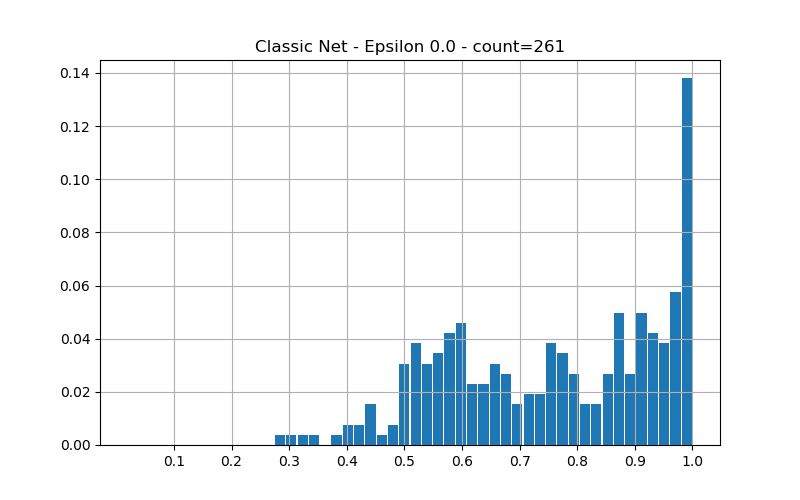

Statistical description of the predictions maximums
DescribeResult(nobs=261, minmax=(0.29110053629830532542, 0.99960376733238808937), mean=0.75990733593663668084, variance=0.03465637976647750446, skewness=-0.3391420007679624638, kurtosis=-1.065780124462686321)

percentage of confident predictions (>=0.5): 0.9272030651340997

Sample predictions
index 122 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 217 prediction [0.04 0.   0.   0.   0.14 0.44 0.33 0.   0.05 0.01]
index 114 prediction [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
index 71 prediction [0.04 0.   0.   0.   0.   0.   0.96 0.   0.   0.  ]
index 76 prediction [0.44 0.   0.01 0.   0.   0.01 0.22 0.   0.32 0.  ]


<IPython.core.display.Javascript object>


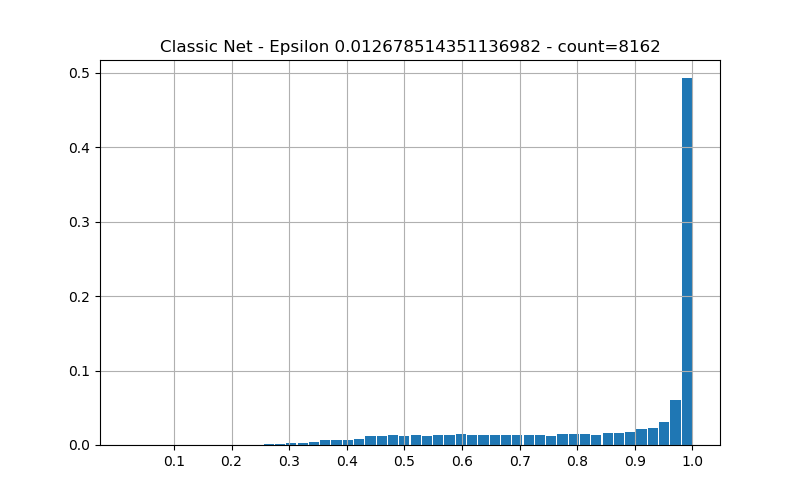

Statistical description of the predictions maximums
DescribeResult(nobs=8162, minmax=(0.24234779965877481601, 0.9998696787100755798), mean=0.8580842313185853932, variance=0.03740726566708798058, skewness=-1.229221722380901041, kurtosis=0.18496006938284663781)

percentage of confident predictions (>=0.5): 0.9139916687086499

Sample predictions
index 7778 prediction [0.   0.02 0.03 0.04 0.   0.27 0.   0.62 0.   0.01]
index 5952 prediction [0.   0.06 0.36 0.04 0.   0.04 0.27 0.   0.23 0.  ]
index 812 prediction [0.49 0.   0.01 0.08 0.   0.   0.01 0.   0.41 0.  ]
index 3141 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2796 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


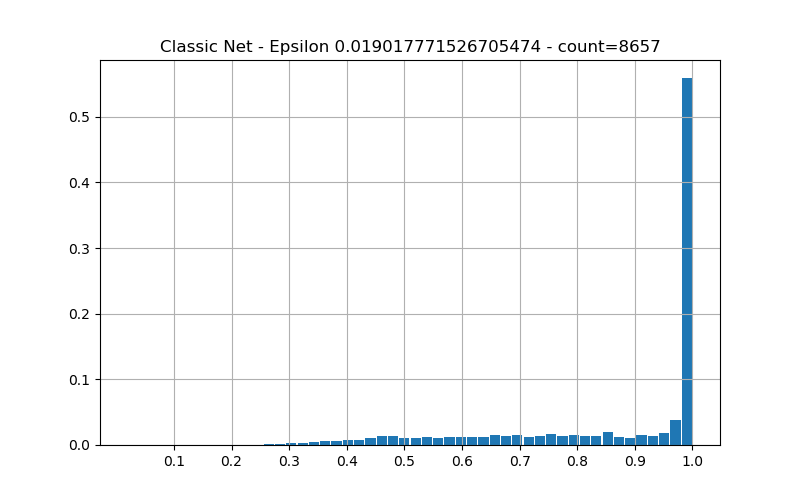

Statistical description of the predictions maximums
DescribeResult(nobs=8657, minmax=(0.21723462851853416391, 0.99964663475888871887), mean=0.865677417265535404, variance=0.037156630130655319057, skewness=-1.2931287557830883946, kurtosis=0.36797651441558188682)

percentage of confident predictions (>=0.5): 0.9159062030726579

Sample predictions
index 1643 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.98 0.  ]
index 5548 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4700 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1165 prediction [0.   0.01 0.07 0.06 0.   0.49 0.   0.36 0.   0.  ]
index 8137 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


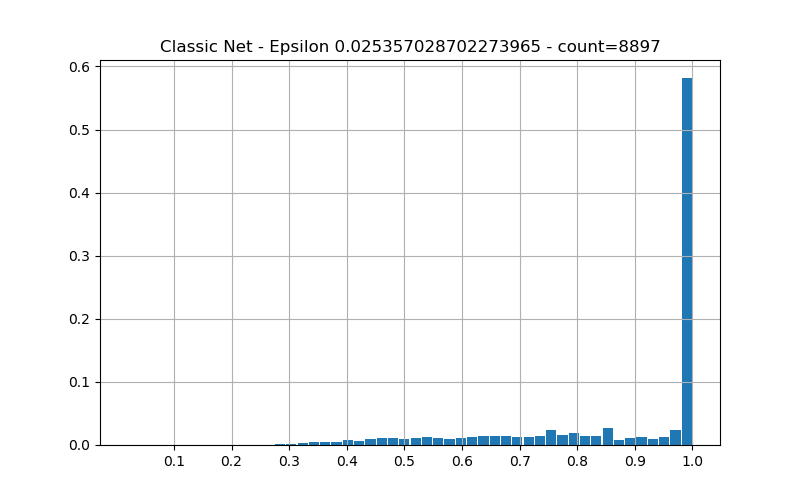

Statistical description of the predictions maximums
DescribeResult(nobs=8897, minmax=(0.25159030617894681932, 0.99971989530751264566), mean=0.8696311596909039685, variance=0.035668261237958629256, skewness=-1.3183341484127005921, kurtosis=0.5029329570040674039)

percentage of confident predictions (>=0.5): 0.9263796785433293

Sample predictions
index 1928 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4781 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5828 prediction [0.03 0.   0.   0.13 0.   0.02 0.   0.   0.79 0.02]
index 3900 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3822 prediction [0.   0.03 0.03 0.04 0.   0.07 0.   0.82 0.   0.  ]


<IPython.core.display.Javascript object>


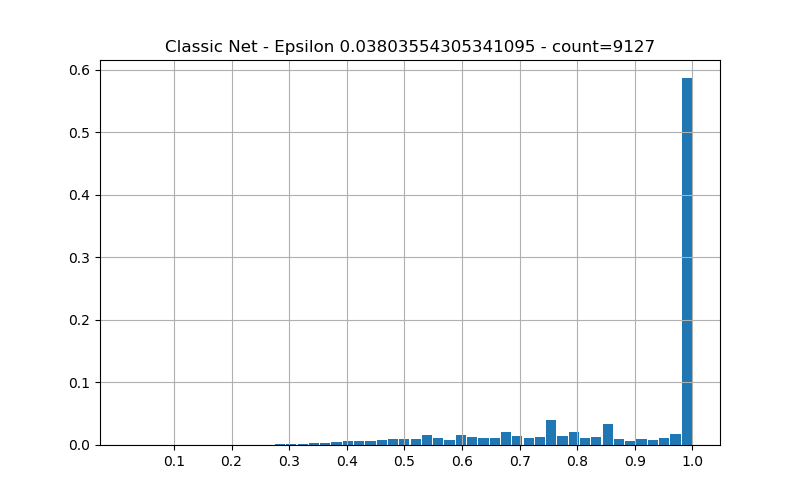

Statistical description of the predictions maximums
DescribeResult(nobs=9127, minmax=(0.23718970928996932974, 0.9998641331793516335), mean=0.87358928290325387026, variance=0.03289030866560450465, skewness=-1.2974590503828514753, kurtosis=0.52418989520069869)

percentage of confident predictions (>=0.5): 0.9406157554508601

Sample predictions
index 8393 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2017 prediction [0.   0.01 0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 9084 prediction [0.72 0.   0.   0.08 0.   0.04 0.   0.   0.14 0.01]
index 5074 prediction [0.   0.09 0.03 0.03 0.   0.14 0.   0.7  0.   0.  ]
index 7880 prediction [0.   0.   0.   0.   0.   0.   0.01 0.   0.99 0.  ]


<IPython.core.display.Javascript object>


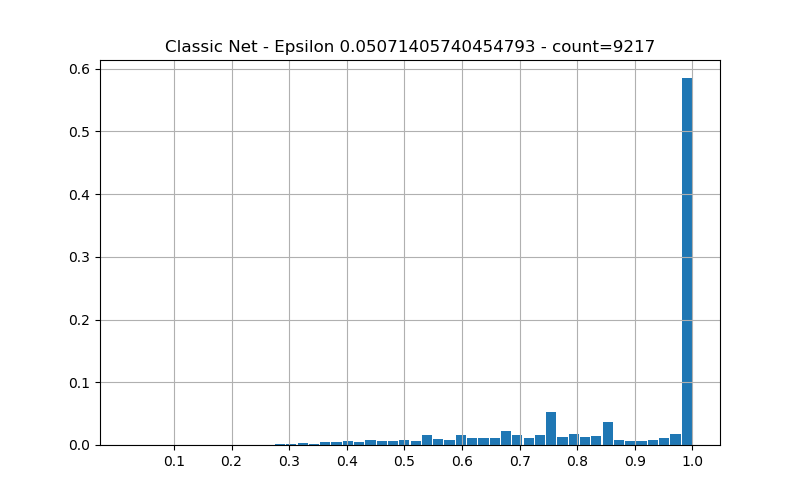

Statistical description of the predictions maximums
DescribeResult(nobs=9217, minmax=(0.24377978458293674696, 0.99978696355257260615), mean=0.87559034955886295347, variance=0.03147192198854716269, skewness=-1.306207908330884783, kurtosis=0.6406829097517079566)

percentage of confident predictions (>=0.5): 0.9468373657372247

Sample predictions
index 2975 prediction [0.   0.01 0.78 0.01 0.   0.01 0.13 0.07 0.   0.  ]
index 8107 prediction [0.   0.07 0.05 0.09 0.   0.1  0.   0.68 0.   0.  ]
index 182 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 69 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7589 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


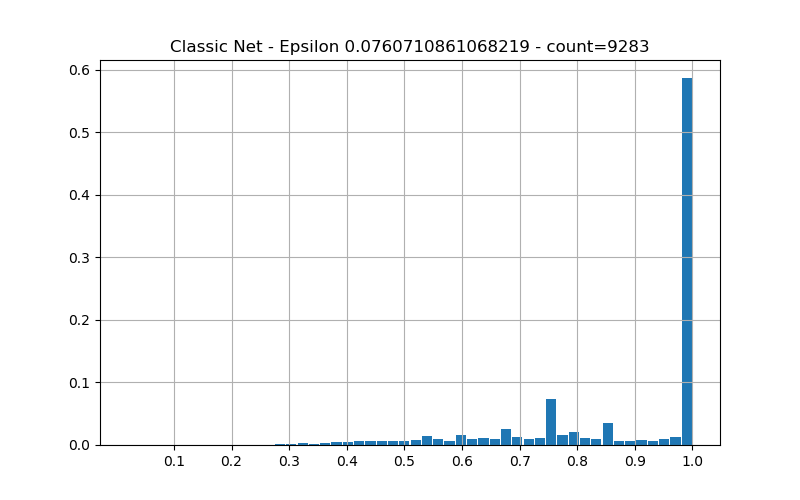

Statistical description of the predictions maximums
DescribeResult(nobs=9283, minmax=(0.21190657112520462138, 0.9998620505035152788), mean=0.876558344500953248, variance=0.030656607477052145653, skewness=-1.3064508346393373417, kurtosis=0.6970876110203586217)

percentage of confident predictions (>=0.5): 0.9493698157923085

Sample predictions
index 2048 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2397 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3204 prediction [0.   0.06 0.07 0.04 0.   0.22 0.   0.61 0.   0.  ]
index 8190 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 8351 prediction [0.   0.08 0.05 0.11 0.   0.15 0.   0.61 0.   0.01]


<IPython.core.display.Javascript object>


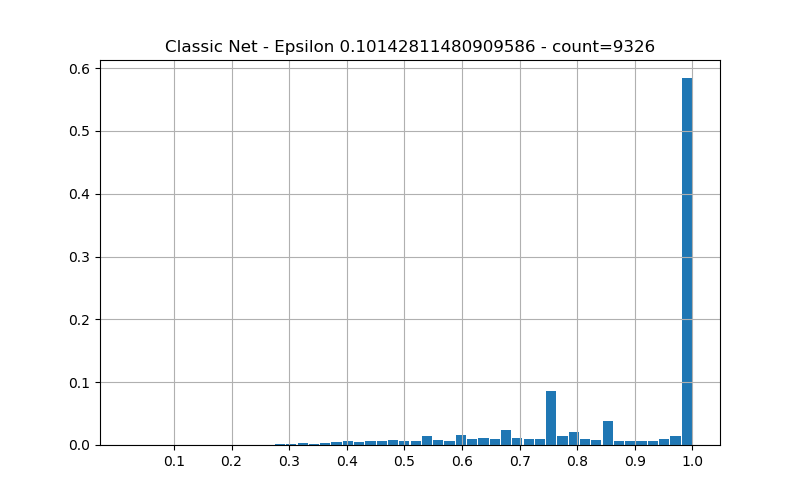

Statistical description of the predictions maximums
DescribeResult(nobs=9326, minmax=(0.2048357562660398664, 0.99986937926957692244), mean=0.87617591111342678193, variance=0.03061652950794482972, skewness=-1.3123628560930539226, kurtosis=0.75717611692758665263)

percentage of confident predictions (>=0.5): 0.948423761526914

Sample predictions
index 6987 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7667 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 851 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.01]
index 8904 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2860 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]


<IPython.core.display.Javascript object>


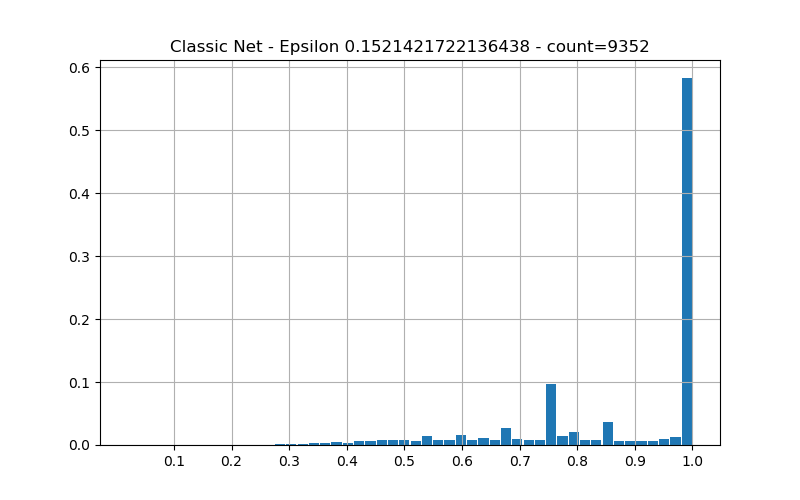

Statistical description of the predictions maximums
DescribeResult(nobs=9352, minmax=(0.23999746876969158922, 0.9998691001321117591), mean=0.8755478311248660841, variance=0.030388151877846400338, skewness=-1.2809545518698133819, kurtosis=0.6519729913918873147)

percentage of confident predictions (>=0.5): 0.9493156544054747

Sample predictions
index 6543 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5127 prediction [0.06 0.02 0.   0.   0.   0.02 0.9  0.   0.   0.  ]
index 7641 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.95 0.03]
index 1379 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6256 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


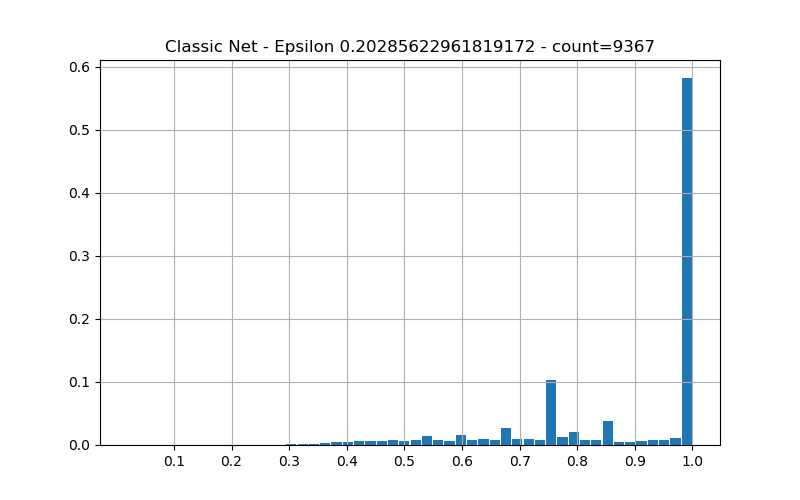

Statistical description of the predictions maximums
DescribeResult(nobs=9367, minmax=(0.22892513379669269577, 0.99986718981775900625), mean=0.87546400112061743994, variance=0.030200227799315769694, skewness=-1.2716323861907378358, kurtosis=0.62794720872746031463)

percentage of confident predictions (>=0.5): 0.9498238496850646

Sample predictions
index 6938 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3999 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.01]
index 1593 prediction [0.   0.07 0.02 0.06 0.   0.05 0.   0.8  0.   0.  ]
index 8800 prediction [0.   0.03 0.02 0.03 0.   0.04 0.   0.86 0.   0.01]
index 4185 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


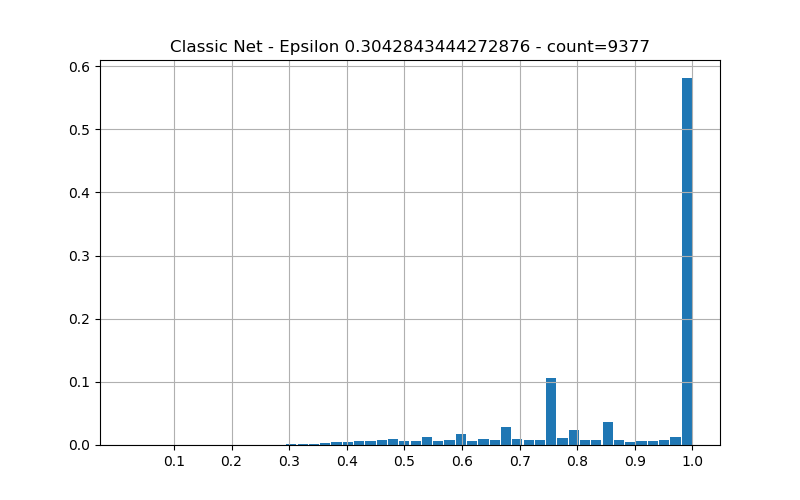

Statistical description of the predictions maximums
DescribeResult(nobs=9377, minmax=(0.21755854652474251034, 0.9998334723975028163), mean=0.87514121114657422604, variance=0.030314245362761370173, skewness=-1.2789290480242961762, kurtosis=0.6707712852769088755)

percentage of confident predictions (>=0.5): 0.9469979737655967

Sample predictions
index 8062 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2379 prediction [0.01 0.   0.01 0.39 0.   0.   0.01 0.57 0.   0.  ]
index 5677 prediction [0.   0.07 0.05 0.09 0.   0.1  0.   0.68 0.   0.  ]
index 3487 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]


<IPython.core.display.Javascript object>


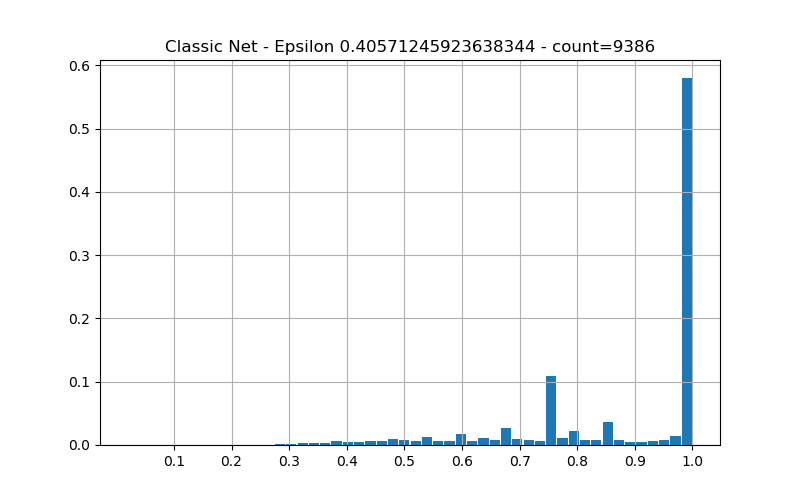

Statistical description of the predictions maximums
DescribeResult(nobs=9386, minmax=(0.2125003500445958592, 0.9997688174380093598), mean=0.87490756269753101643, variance=0.030389677803785354946, skewness=-1.2801418892767238801, kurtosis=0.6768584998831717748)

percentage of confident predictions (>=0.5): 0.9471553377370552

Sample predictions
index 1491 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8565 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 3564 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7454 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3385 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


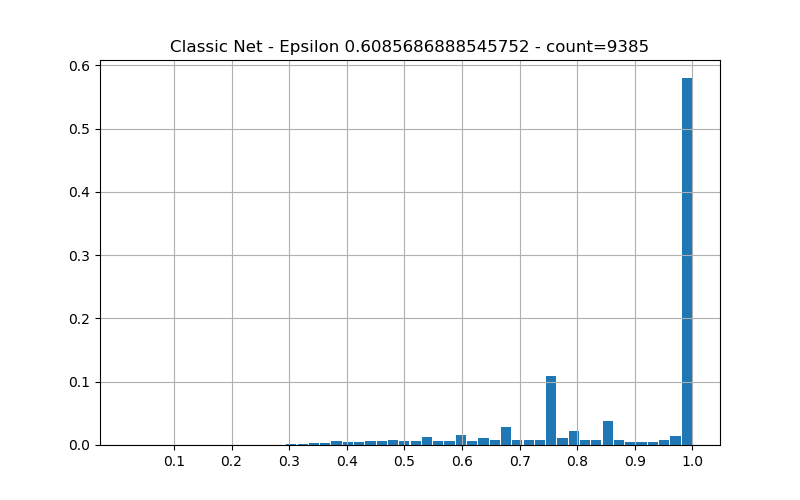

Statistical description of the predictions maximums
DescribeResult(nobs=9385, minmax=(0.24164233141891747227, 0.9997094939943623734), mean=0.8755691806780219263, variance=0.030041348772665086578, skewness=-1.2831401918401872341, kurtosis=0.694286468569316447)

percentage of confident predictions (>=0.5): 0.9486414491209376

Sample predictions
index 4344 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 3022 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1862 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1684 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5353 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


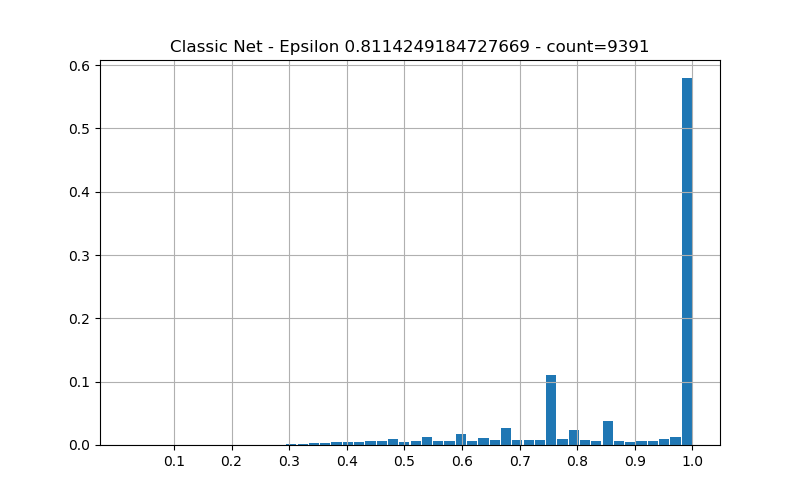

Statistical description of the predictions maximums
DescribeResult(nobs=9391, minmax=(0.24014880420877146018, 0.9995791236427528261), mean=0.87587077249751013565, variance=0.02983106916751398438, skewness=-1.2815538410080223053, kurtosis=0.69393767316034622814)

percentage of confident predictions (>=0.5): 0.9493131721861356

Sample predictions
index 9193 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5236 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8892 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5756 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 582 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


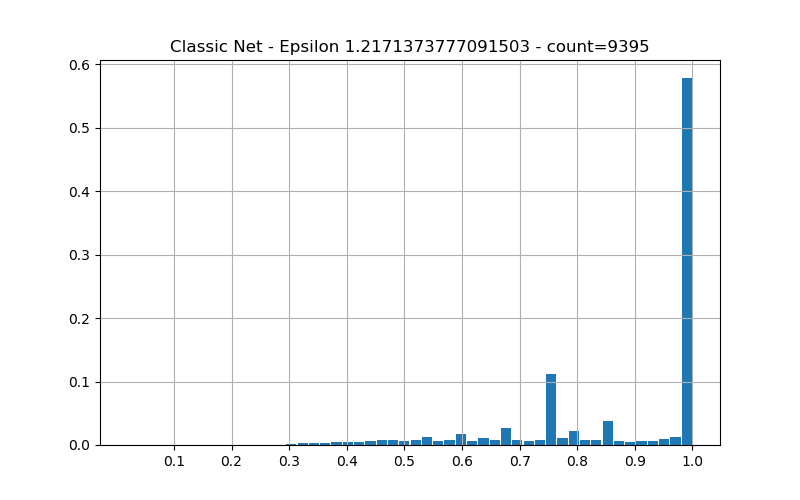

Statistical description of the predictions maximums
DescribeResult(nobs=9395, minmax=(0.24164233141891747227, 0.99951060579194664075), mean=0.87592163869798312617, variance=0.029707425120753120374, skewness=-1.2730896648562962561, kurtosis=0.6609519844390478768)

percentage of confident predictions (>=0.5): 0.9499733901011176

Sample predictions
index 1405 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 448 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 8730 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8652 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 9071 prediction [0.   0.01 0.04 0.05 0.   0.85 0.01 0.04 0.   0.  ]


<IPython.core.display.Javascript object>


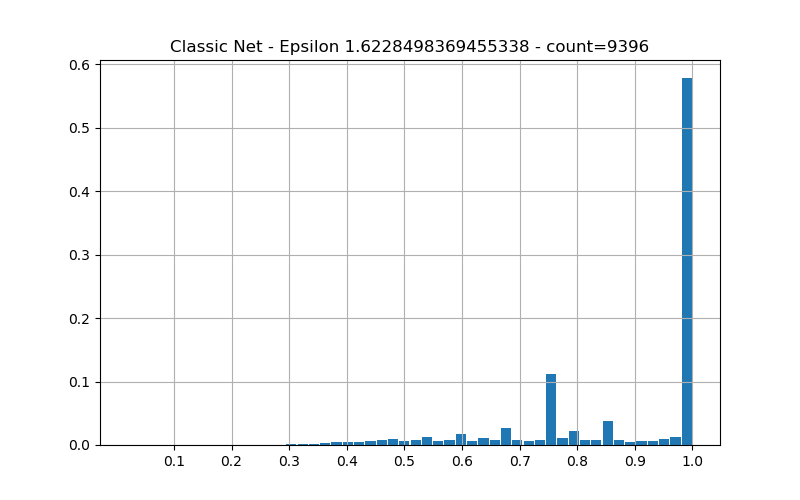

Statistical description of the predictions maximums
DescribeResult(nobs=9396, minmax=(0.24164233141891747227, 0.99951060579194664075), mean=0.875899065846127964, variance=0.029619664970037319783, skewness=-1.2648886945676270291, kurtosis=0.62807063682597465094)

percentage of confident predictions (>=0.5): 0.9501915708812261

Sample predictions
index 6001 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2851 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 735 prediction [0.01 0.   0.   0.67 0.02 0.   0.02 0.24 0.04 0.01]
index 6623 prediction [0.   0.05 0.03 0.03 0.   0.04 0.   0.84 0.   0.  ]
index 9192 prediction [0.   0.05 0.03 0.01 0.   0.26 0.   0.64 0.   0.  ]


<IPython.core.display.Javascript object>


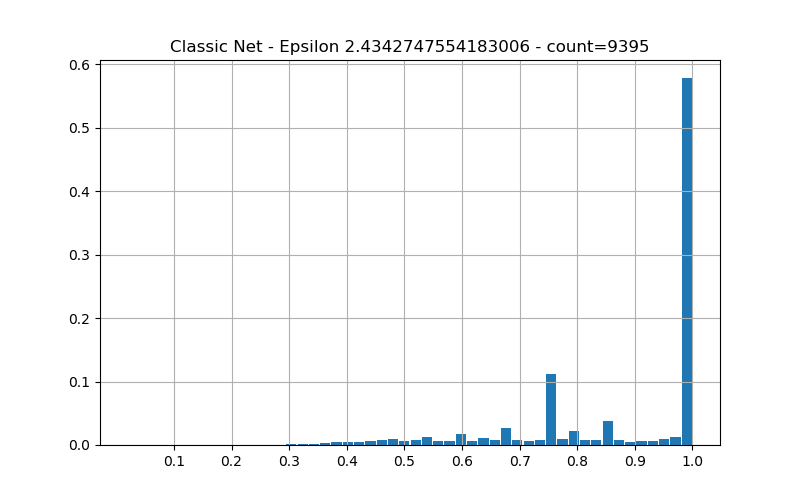

Statistical description of the predictions maximums
DescribeResult(nobs=9395, minmax=(0.22862903974536644201, 0.99951060579194664075), mean=0.8761129126146323715, variance=0.029524182316971939328, skewness=-1.2680469086073553913, kurtosis=0.6506741312857183038)

percentage of confident predictions (>=0.5): 0.9507184672698243

Sample predictions
index 9308 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 4737 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 4528 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7529 prediction [0.   0.06 0.02 0.1  0.   0.11 0.   0.7  0.   0.  ]
index 6825 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


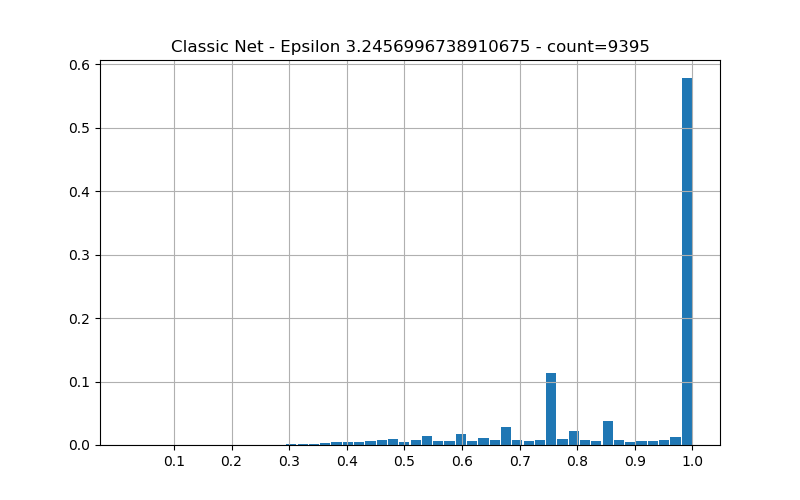

Statistical description of the predictions maximums
DescribeResult(nobs=9395, minmax=(0.2286231658212988858, 0.99951060579194664075), mean=0.87616880641378061973, variance=0.029472089440248728403, skewness=-1.2672026736659543422, kurtosis=0.64885144319874732497)

percentage of confident predictions (>=0.5): 0.951037786056413

Sample predictions
index 7446 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6280 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6363 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 108 prediction [0.   0.   0.   0.02 0.   0.05 0.   0.   0.92 0.  ]
index 4324 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.01]


In [33]:
# rerun the classic model on adv examples
for i ,classic_raw_images in enumerate(classic_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(classic_raw_images))
    t = 'Classic Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(classic_model, dl, title=t, verbose=True)

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_pred_histogram.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)


<IPython.core.display.Javascript object>


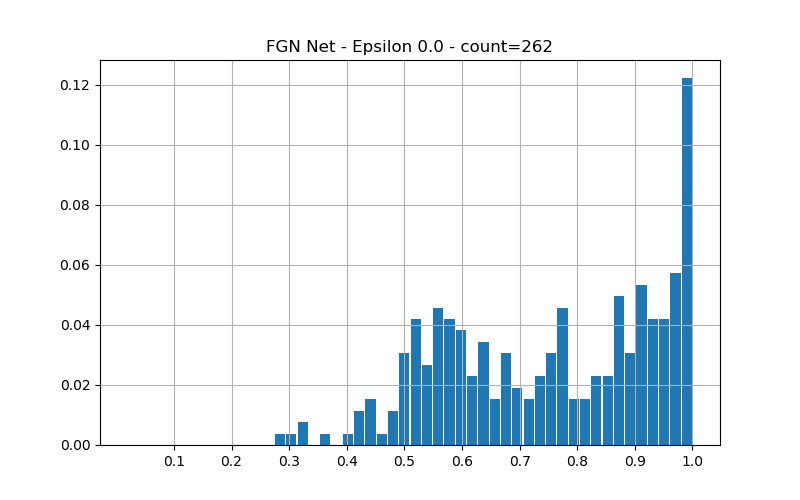

Statistical description of the predictions maximums
DescribeResult(nobs=262, minmax=(0.291198679220571541, 0.99955583901393187514), mean=0.75594638905529877267, variance=0.03489159756413738203, skewness=-0.31839214001747279597, kurtosis=-1.0829142552339797234)

percentage of confident predictions (>=0.5): 0.9198473282442748

Sample predictions
index 128 prediction [0.   0.01 0.   0.44 0.   0.55 0.   0.   0.   0.  ]
index 209 prediction [0.01 0.   0.34 0.03 0.   0.   0.   0.6  0.01 0.  ]
index 27 prediction [0.54 0.   0.01 0.   0.   0.   0.43 0.   0.02 0.  ]
index 0 prediction [0.   0.   0.   0.   0.   0.   0.78 0.   0.21 0.  ]
index 198 prediction [0.   0.   0.   0.   0.   0.01 0.99 0.   0.   0.  ]


<IPython.core.display.Javascript object>


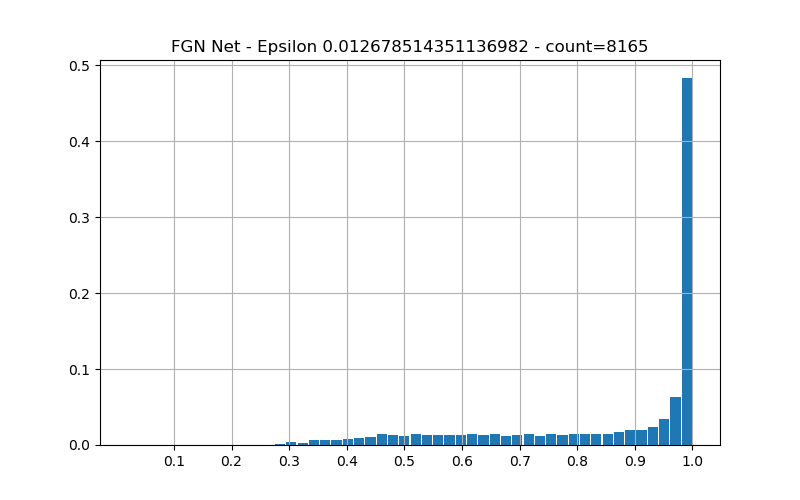

Statistical description of the predictions maximums
DescribeResult(nobs=8165, minmax=(0.24075409386075662296, 0.9997280505817664104), mean=0.85489570457434934915, variance=0.03821329885131647245, skewness=-1.2036146845614152092, kurtosis=0.1054305927650557933)

percentage of confident predictions (>=0.5): 0.9115737905695039

Sample predictions
index 4030 prediction [0.   0.05 0.16 0.06 0.   0.06 0.   0.67 0.   0.  ]
index 135 prediction [0.   0.   0.   0.   0.   0.01 0.01 0.   0.97 0.  ]
index 4363 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5179 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 520 prediction [0.   0.06 0.09 0.06 0.   0.1  0.   0.68 0.   0.  ]


<IPython.core.display.Javascript object>


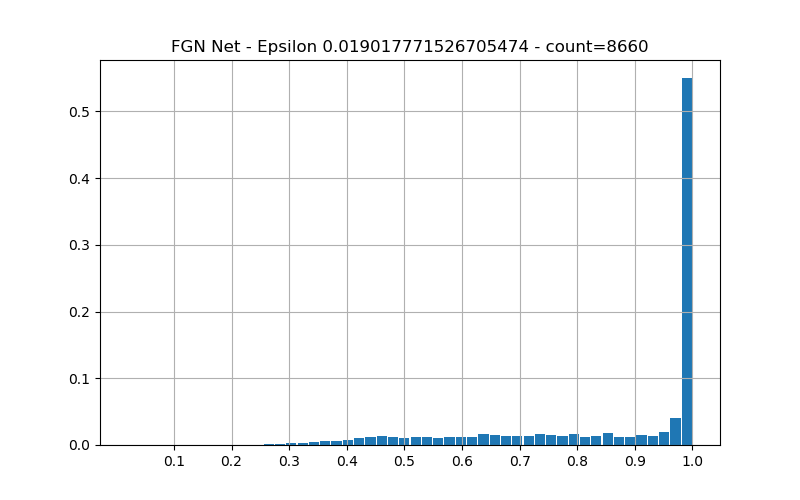

Statistical description of the predictions maximums
DescribeResult(nobs=8660, minmax=(0.21776872234303427919, 0.9997072841243939254), mean=0.86177096136714260874, variance=0.038121741983626573838, skewness=-1.2552668538965352508, kurtosis=0.25378606570648690362)

percentage of confident predictions (>=0.5): 0.9124711316397228

Sample predictions
index 8306 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3733 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 886 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2050 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2977 prediction [0.   0.05 0.09 0.1  0.   0.22 0.   0.53 0.   0.  ]


<IPython.core.display.Javascript object>


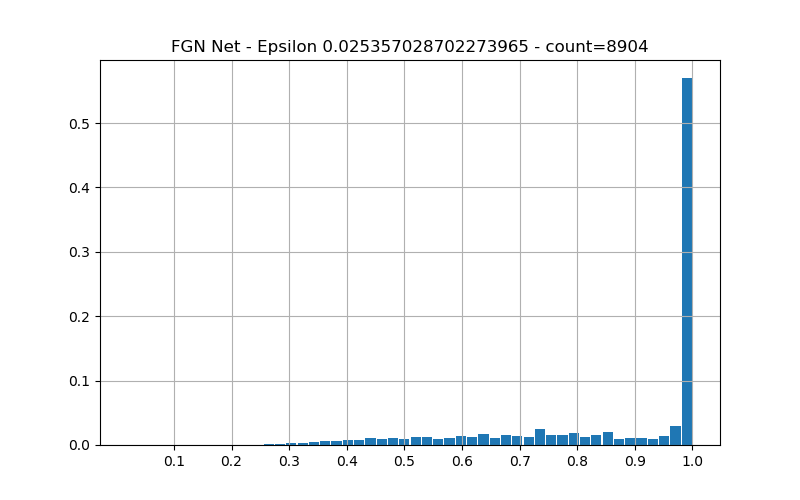

Statistical description of the predictions maximums
DescribeResult(nobs=8904, minmax=(0.23814272830299400785, 0.99964347865500282177), mean=0.8644587722152327922, variance=0.037045395846305623376, skewness=-1.2662713993717868249, kurtosis=0.33966921536370295602)

percentage of confident predictions (>=0.5): 0.9211590296495957

Sample predictions
index 5772 prediction [0.01 0.   0.   0.02 0.   0.07 0.   0.   0.9  0.  ]
index 1334 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7409 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 6464 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5847 prediction [0.   0.01 0.   0.1  0.   0.   0.   0.   0.86 0.02]


<IPython.core.display.Javascript object>


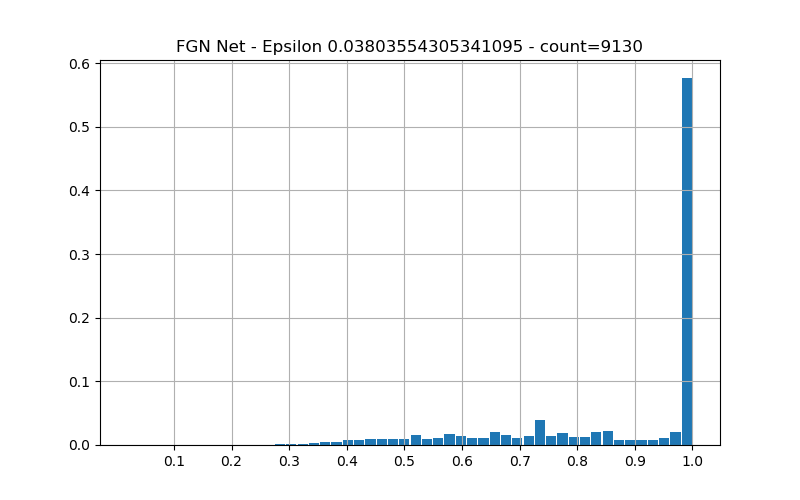

Statistical description of the predictions maximums
DescribeResult(nobs=9130, minmax=(0.22927556942228821561, 0.9997867146839758856), mean=0.8654527476220833213, variance=0.03493575288445682588, skewness=-1.2076684010129379038, kurtosis=0.22292314832087696758)

percentage of confident predictions (>=0.5): 0.9343921139101862

Sample predictions
index 1354 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 2356 prediction [0.   0.06 0.59 0.02 0.   0.01 0.03 0.29 0.   0.  ]
index 286 prediction [0.   0.03 0.06 0.09 0.   0.37 0.   0.44 0.   0.  ]
index 7879 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4473 prediction [0.   0.06 0.06 0.07 0.   0.36 0.   0.45 0.   0.  ]


<IPython.core.display.Javascript object>


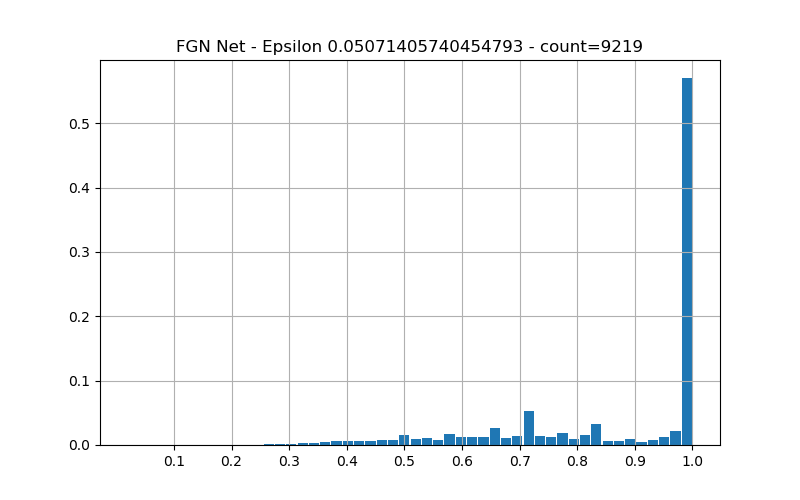

Statistical description of the predictions maximums
DescribeResult(nobs=9219, minmax=(0.2435978733473020712, 0.9997864317032956844), mean=0.86298886079512921615, variance=0.034631349864485250483, skewness=-1.1735041686427448183, kurtosis=0.18895674887364402096)

percentage of confident predictions (>=0.5): 0.9404490725675236

Sample predictions
index 5703 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 6646 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 359 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 6998 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 5379 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


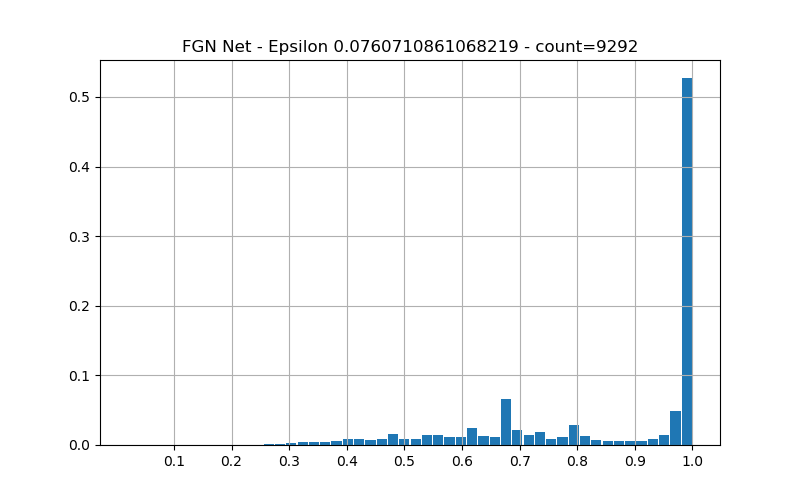

Statistical description of the predictions maximums
DescribeResult(nobs=9292, minmax=(0.22240897049190510798, 0.99940188035224353144), mean=0.8478113670226290589, variance=0.037365443985949042233, skewness=-1.0334783699863886374, kurtosis=-0.20603492619972353888)

percentage of confident predictions (>=0.5): 0.9241282823934568

Sample predictions
index 6883 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 8254 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 1838 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 1675 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.99 0.  ]
index 1846 prediction [0.   0.07 0.07 0.1  0.   0.12 0.   0.63 0.   0.01]


<IPython.core.display.Javascript object>


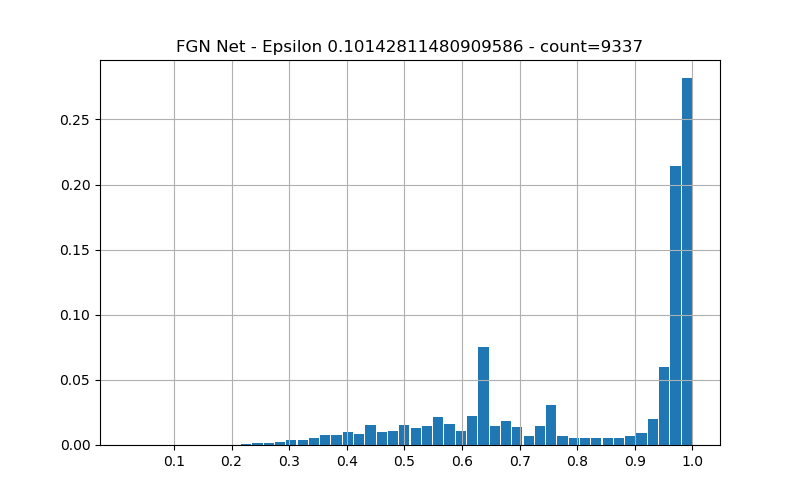

Statistical description of the predictions maximums
DescribeResult(nobs=9337, minmax=(0.20798320766855598639, 0.99833735777168344463), mean=0.81980866405246440395, variance=0.0413735147455368487, skewness=-0.87727456659769778395, kurtosis=-0.6074869838830398712)

percentage of confident predictions (>=0.5): 0.906286815893756

Sample predictions
index 7281 prediction [0.   0.09 0.07 0.13 0.   0.12 0.   0.58 0.   0.01]
index 8202 prediction [0.   0.05 0.09 0.08 0.   0.13 0.   0.63 0.   0.01]
index 765 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.97 0.01]
index 8777 prediction [0.   0.24 0.11 0.08 0.   0.07 0.   0.49 0.   0.01]
index 7884 prediction [0.   0.   0.   0.   0.   0.05 0.   0.   0.94 0.  ]


<IPython.core.display.Javascript object>


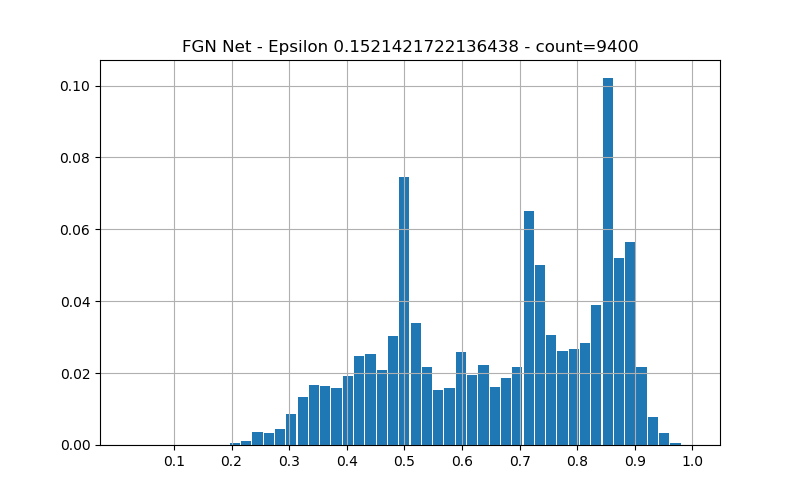

Statistical description of the predictions maximums
DescribeResult(nobs=9400, minmax=(0.17568322180632857542, 0.98717853376689434944), mean=0.6633659291192878661, variance=0.032977917515478106354, skewness=-0.35034103656646516122, kurtosis=-1.1015698374263485402)

percentage of confident predictions (>=0.5): 0.7684042553191489

Sample predictions
index 9101 prediction [0.05 0.02 0.07 0.12 0.   0.05 0.01 0.02 0.6  0.06]
index 4696 prediction [0.03 0.22 0.16 0.09 0.1  0.13 0.04 0.19 0.   0.03]
index 1349 prediction [0.   0.01 0.02 0.07 0.   0.04 0.   0.01 0.83 0.03]
index 2827 prediction [0.   0.   0.01 0.09 0.   0.12 0.   0.   0.75 0.02]
index 5513 prediction [0.   0.01 0.02 0.11 0.   0.11 0.   0.01 0.69 0.04]


<IPython.core.display.Javascript object>


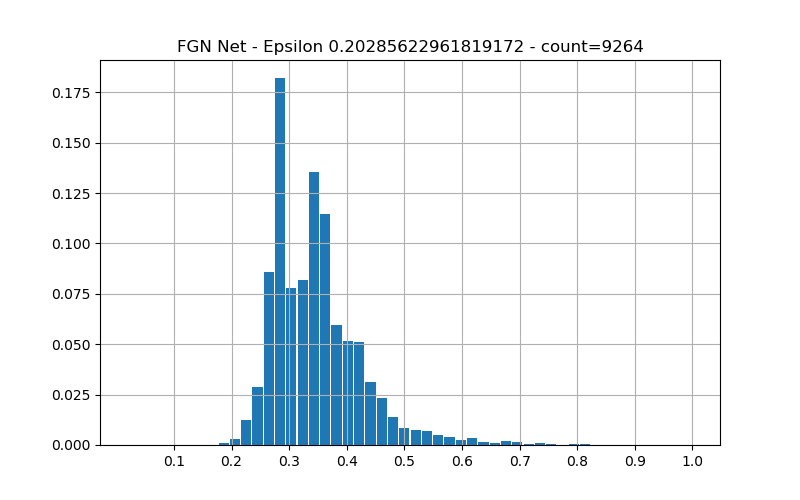

Statistical description of the predictions maximums
DescribeResult(nobs=9264, minmax=(0.17209406304629367714, 0.95902893492262545374), mean=0.34570069980048295362, variance=0.0061755745285491666276, skewness=1.5413727996228098109, kurtosis=4.307280304061033755)

percentage of confident predictions (>=0.5): 0.04199050086355786

Sample predictions
index 5515 prediction [0.01 0.03 0.06 0.26 0.01 0.22 0.01 0.05 0.3  0.06]
index 3753 prediction [0.   0.11 0.11 0.14 0.01 0.16 0.01 0.42 0.   0.03]
index 5273 prediction [0.02 0.04 0.04 0.06 0.02 0.2  0.58 0.01 0.04 0.  ]
index 8107 prediction [0.02 0.05 0.1  0.22 0.01 0.09 0.01 0.09 0.35 0.07]
index 8061 prediction [0.   0.13 0.12 0.19 0.01 0.18 0.01 0.31 0.   0.03]


<IPython.core.display.Javascript object>


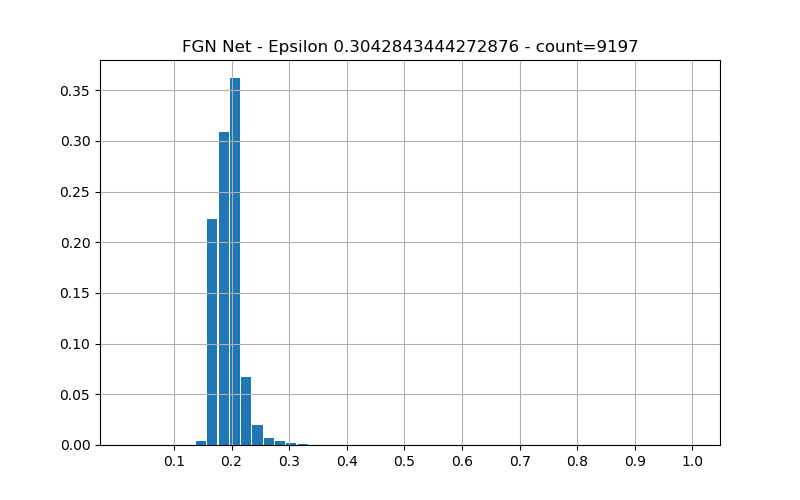

Statistical description of the predictions maximums
DescribeResult(nobs=9197, minmax=(0.14594510391560034029, 0.5161796895519359709), mean=0.19454424540768566152, variance=0.00045272539848299149122, skewness=2.0657629364301004656, kurtosis=14.10633883697013265)

percentage of confident predictions (>=0.5): 0.00010873110796999022

Sample predictions
index 4370 prediction [0.01 0.15 0.13 0.18 0.04 0.18 0.05 0.18 0.03 0.05]
index 6302 prediction [0.03 0.1  0.13 0.19 0.05 0.16 0.04 0.12 0.1  0.07]
index 1618 prediction [0.02 0.09 0.12 0.24 0.05 0.15 0.03 0.12 0.1  0.09]
index 1068 prediction [0.03 0.1  0.13 0.19 0.05 0.16 0.04 0.12 0.1  0.07]
index 2619 prediction [0.03 0.15 0.12 0.16 0.06 0.2  0.08 0.11 0.05 0.05]


<IPython.core.display.Javascript object>


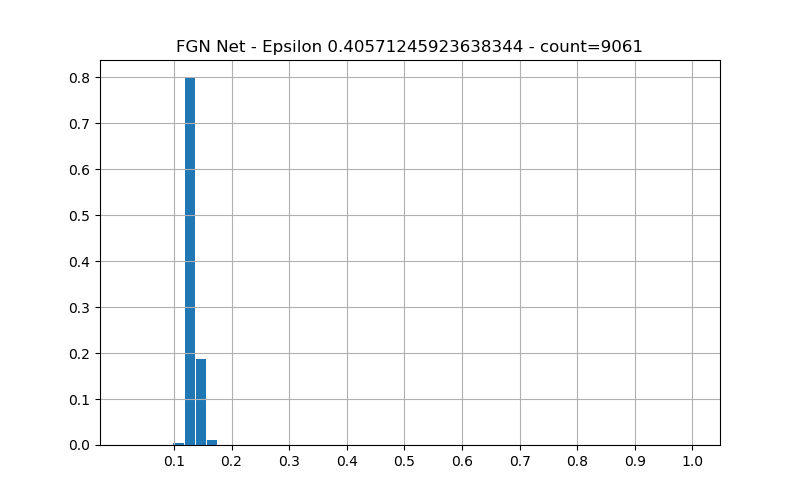

Statistical description of the predictions maximums
DescribeResult(nobs=9061, minmax=(0.1128651606631303427, 0.2046561253514617338), mean=0.13298631152121920904, variance=5.1304522153547783274e-05, skewness=1.6763646361798333903, kurtosis=6.6512250394036740763)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3991 prediction [0.04 0.12 0.12 0.14 0.08 0.13 0.09 0.1  0.09 0.08]
index 6909 prediction [0.05 0.11 0.12 0.13 0.09 0.13 0.1  0.1  0.09 0.08]
index 8446 prediction [0.04 0.11 0.13 0.15 0.07 0.15 0.07 0.11 0.09 0.07]
index 7253 prediction [0.06 0.11 0.12 0.13 0.09 0.12 0.1  0.09 0.1  0.08]
index 6009 prediction [0.04 0.11 0.13 0.15 0.08 0.14 0.07 0.11 0.1  0.08]


<IPython.core.display.Javascript object>


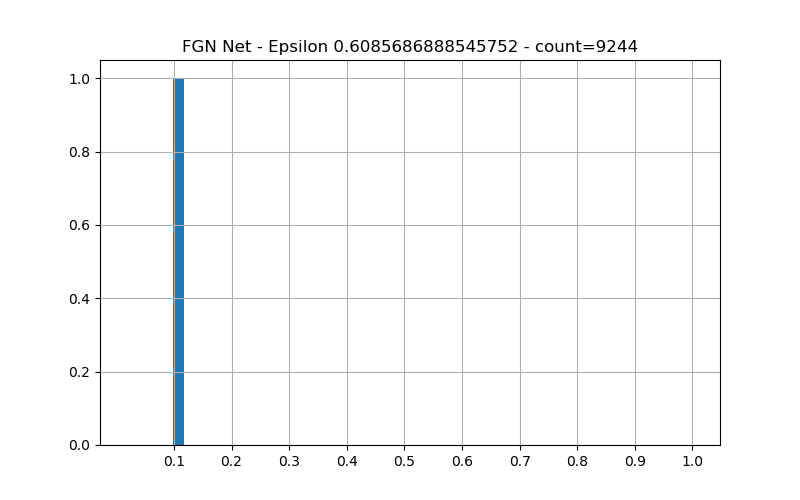

Statistical description of the predictions maximums
DescribeResult(nobs=9244, minmax=(0.10071364131083587952, 0.113444692165650550634), mean=0.10334071516374617435, variance=1.4605584357210128745e-06, skewness=2.157223285252307095, kurtosis=7.9506108943496077903)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7869 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 1703 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3544 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7432 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 4796 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]


<IPython.core.display.Javascript object>


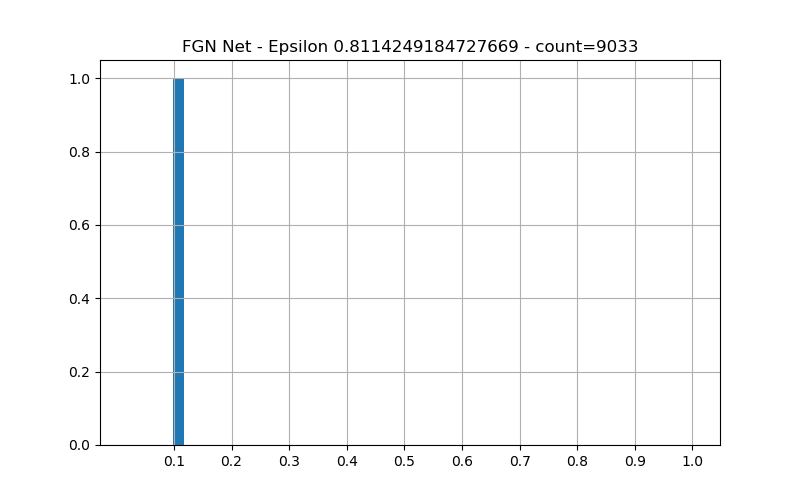

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.100013339891999906024, 0.10215462275971974707), mean=0.10025798230847325596, variance=2.9818604121109738207e-08, skewness=3.0551490187258816646, kurtosis=14.989593499204460695)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5844 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4167 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3665 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 125 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6387 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


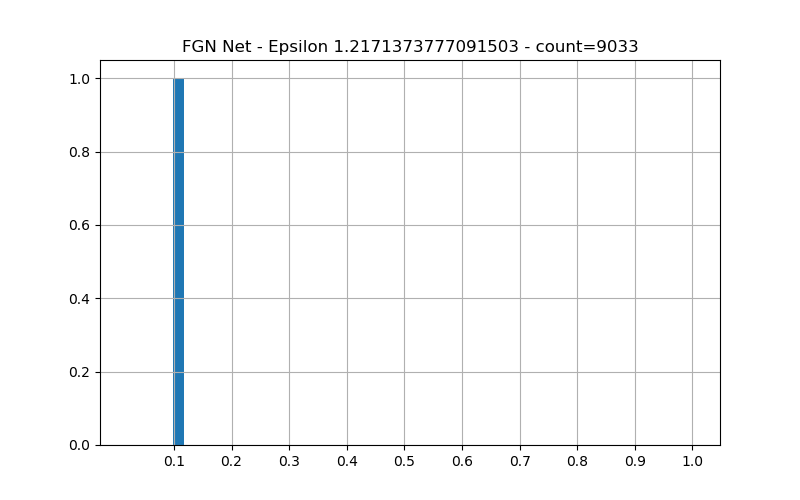

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000014156424344, 0.10001648104387437746), mean=0.10000020114532582574, variance=3.1647078037061027657e-13, skewness=10.752376339053360552, kurtosis=177.53653598584673975)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 305 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1811 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7572 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5761 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6572 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


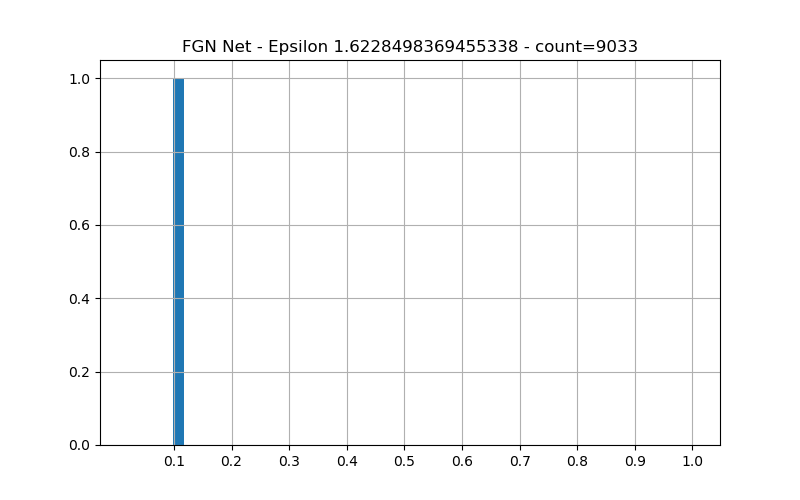

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000000000001536, 0.10000001561387441523), mean=0.10000000002894696493, variance=7.9912504931073374767e-20, skewness=29.437547645056103452, kurtosis=1265.1118561663531914)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2320 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3652 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5827 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 875 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6316 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


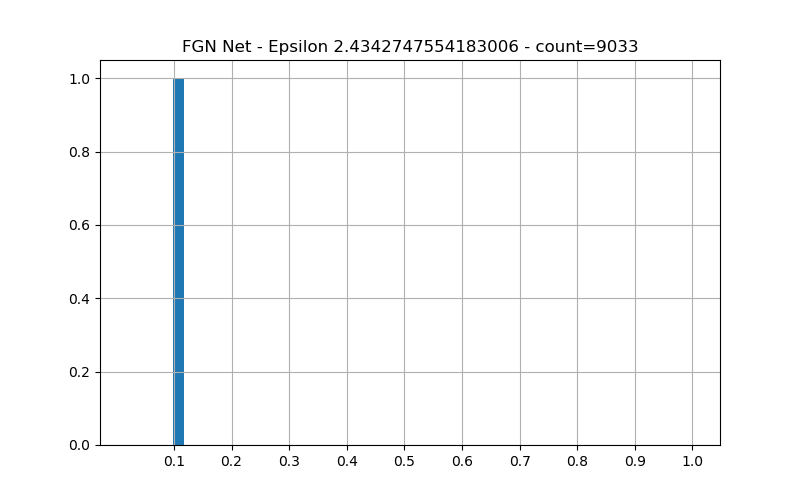

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.10000000000000003582), mean=0.10000000000000000002, variance=1.656090793573228551e-37, skewness=78.456119521415261034, kurtosis=6710.856176213595843)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3778 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4204 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1638 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5206 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4153 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


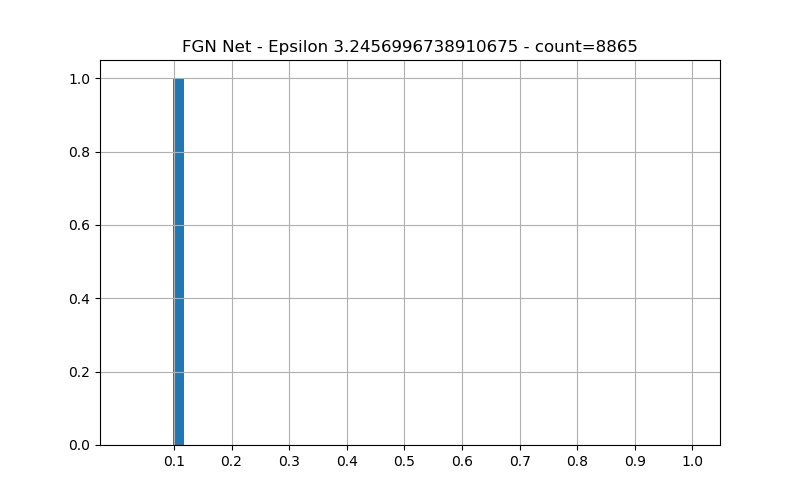

Statistical description of the predictions maximums
DescribeResult(nobs=8865, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.836917133214332334e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4707 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1862 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2305 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2222 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6444 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [34]:
# rerun the fgn model on adv examples
for i ,fgn_raw_images in enumerate(fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(fgn_raw_images))
    t = 'FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(fgn_model, dl, title=t, verbose=True)

<IPython.core.display.Javascript object>


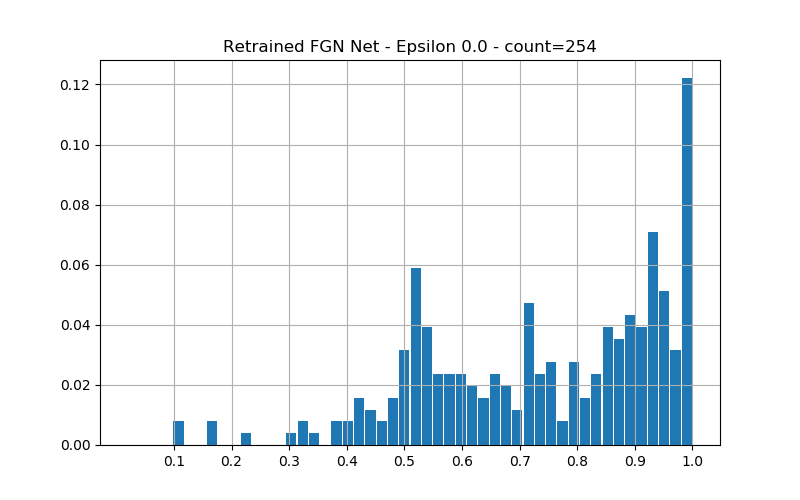

Statistical description of the predictions maximums
DescribeResult(nobs=254, minmax=(0.1051417526762841403, 0.99958332298009816894), mean=0.7430980323882771262, variance=0.04279309253935263563, skewness=-0.61875176657984237694, kurtosis=-0.37099319807730830466)

percentage of confident predictions (>=0.5): 0.8779527559055118

Sample predictions
index 45 prediction [0.   0.   0.   0.   0.   0.11 0.   0.   0.22 0.66]
index 85 prediction [0.62 0.   0.01 0.22 0.   0.04 0.   0.03 0.01 0.06]
index 144 prediction [0.   0.04 0.02 0.84 0.   0.09 0.   0.   0.   0.  ]
index 105 prediction [0.   0.   0.01 0.26 0.   0.   0.   0.72 0.   0.  ]
index 67 prediction [0.   0.05 0.   0.   0.   0.   0.82 0.   0.12 0.  ]


<IPython.core.display.Javascript object>


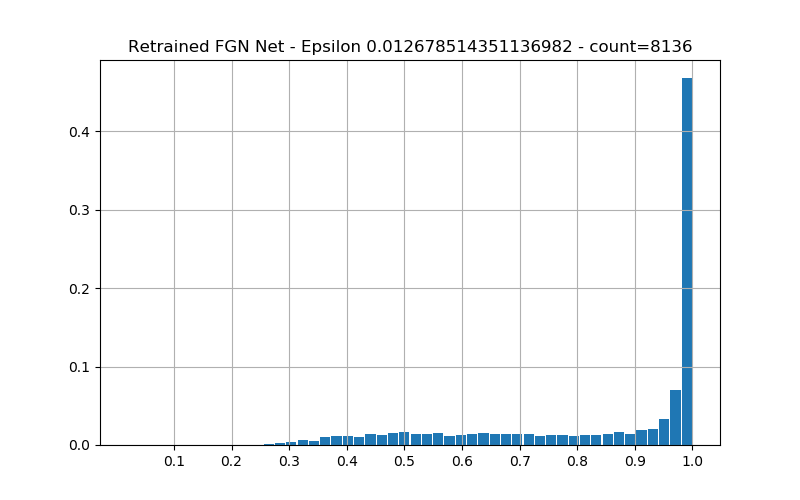

Statistical description of the predictions maximums
DescribeResult(nobs=8136, minmax=(0.10526154348702903412, 0.9997051679229849744), mean=0.84091659134418415085, variance=0.043473591777463072464, skewness=-1.1065044205244610792, kurtosis=-0.18335912440240198593)

percentage of confident predictions (>=0.5): 0.8876597836774828

Sample predictions
index 6673 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 656 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 2111 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3536 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 388 prediction [0.   0.02 0.1  0.02 0.   0.07 0.   0.78 0.   0.01]


<IPython.core.display.Javascript object>


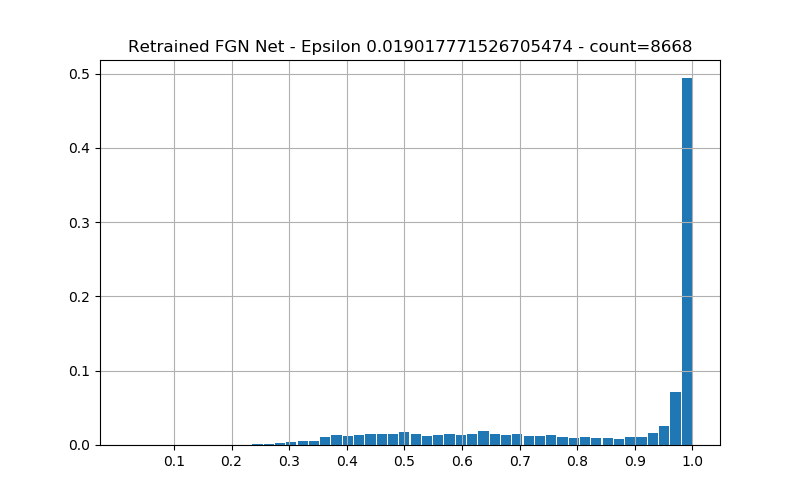

Statistical description of the predictions maximums
DescribeResult(nobs=8668, minmax=(0.10524933250115026732, 0.99885486248430313425), mean=0.8365759948463125134, variance=0.04592107802995364657, skewness=-1.0445309414090924, kurtosis=-0.38619182699996004835)

percentage of confident predictions (>=0.5): 0.8777111213659436

Sample predictions
index 666 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 73 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4542 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 2970 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4797 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


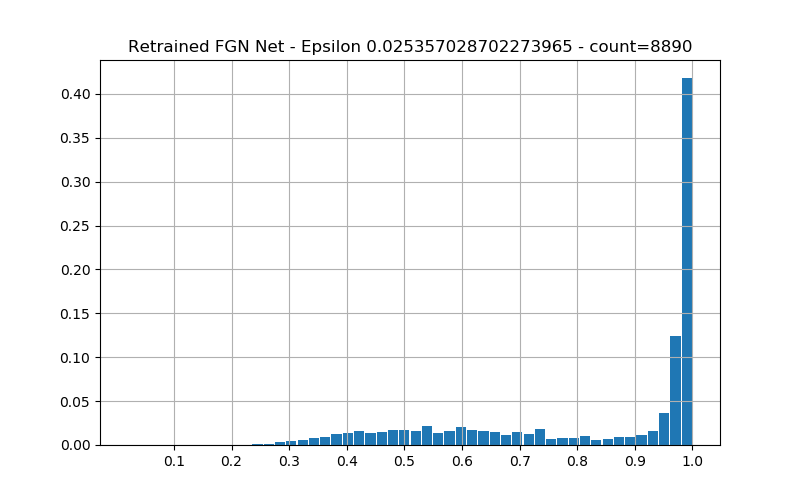

Statistical description of the predictions maximums
DescribeResult(nobs=8890, minmax=(0.10515315504898451631, 0.9980772393590707545), mean=0.82365194026494121854, variance=0.047930302671832806405, skewness=-0.9518594422115781803, kurtosis=-0.59603310123273749816)

percentage of confident predictions (>=0.5): 0.8698537682789651

Sample predictions
index 5146 prediction [0.   0.53 0.35 0.04 0.   0.01 0.   0.06 0.   0.  ]
index 574 prediction [0.   0.07 0.04 0.13 0.   0.12 0.   0.64 0.   0.01]
index 4186 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.98 0.  ]
index 109 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.  ]
index 4005 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


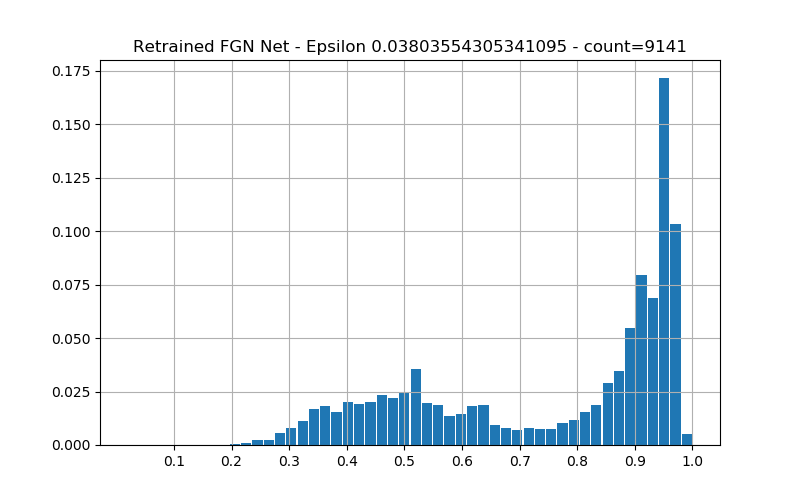

Statistical description of the predictions maximums
DescribeResult(nobs=9141, minmax=(0.104892063061536106414, 0.99140979875534989823), mean=0.7530260533675606138, variance=0.049425704347805310637, skewness=-0.6633353382016241456, kurtosis=-1.1012478711301726868)

percentage of confident predictions (>=0.5): 0.8033037960835795

Sample predictions
index 4290 prediction [0.01 0.13 0.7  0.01 0.   0.   0.06 0.08 0.   0.  ]
index 4586 prediction [0.   0.07 0.11 0.12 0.   0.16 0.   0.52 0.   0.01]
index 5500 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.96 0.01]
index 8719 prediction [0.01 0.02 0.03 0.09 0.   0.03 0.   0.01 0.78 0.02]
index 3164 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.97 0.01]


<IPython.core.display.Javascript object>


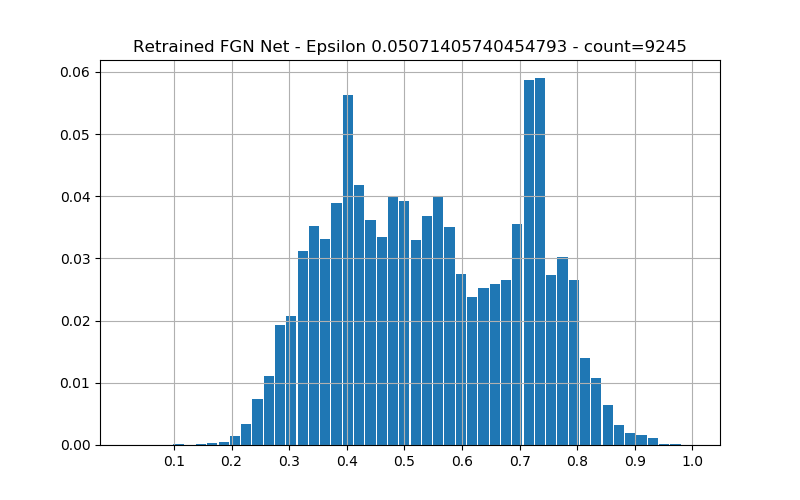

Statistical description of the predictions maximums
DescribeResult(nobs=9245, minmax=(0.104473665738442756605, 0.9727953188905988163), mean=0.54724974977775704503, variance=0.0263579737486339466, skewness=0.060451335462847486107, kurtosis=-1.0854654940596220818)

percentage of confident predictions (>=0.5): 0.5656030286641428

Sample predictions
index 3767 prediction [0.01 0.03 0.04 0.13 0.01 0.13 0.01 0.03 0.6  0.02]
index 6334 prediction [0.01 0.02 0.04 0.09 0.01 0.08 0.01 0.02 0.72 0.01]
index 9105 prediction [0.   0.08 0.12 0.18 0.01 0.25 0.01 0.32 0.   0.02]
index 2037 prediction [0.   0.01 0.02 0.1  0.   0.07 0.   0.01 0.76 0.02]
index 8959 prediction [0.01 0.02 0.03 0.1  0.   0.05 0.   0.01 0.74 0.04]


<IPython.core.display.Javascript object>


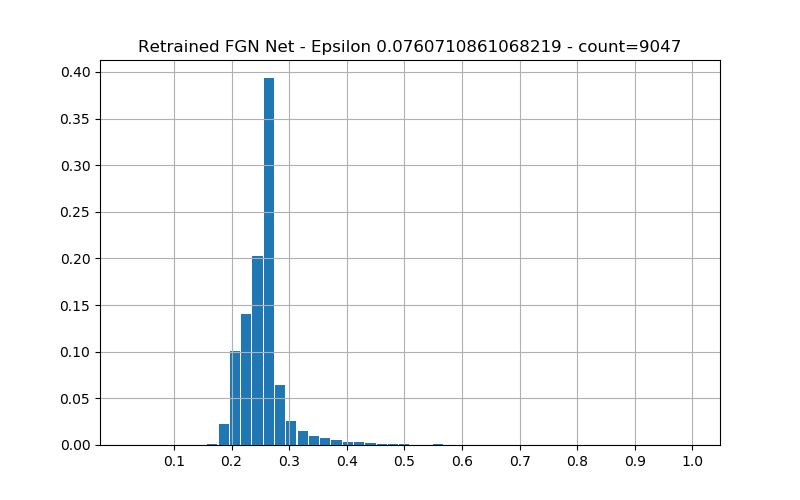

Statistical description of the predictions maximums
DescribeResult(nobs=9047, minmax=(0.10329939393363572651, 0.7401685951938597155), mean=0.2547731845438848878, variance=0.0015012196550735516612, skewness=2.4336219540249208412, kurtosis=14.4728913727351259175)

percentage of confident predictions (>=0.5): 0.0022106775726760254

Sample predictions
index 6039 prediction [0.02 0.14 0.12 0.22 0.03 0.19 0.06 0.17 0.02 0.03]
index 4792 prediction [0.01 0.06 0.13 0.27 0.02 0.17 0.02 0.1  0.16 0.07]
index 5624 prediction [0.01 0.13 0.15 0.19 0.03 0.18 0.03 0.21 0.02 0.05]
index 4154 prediction [0.01 0.08 0.14 0.24 0.03 0.16 0.02 0.13 0.11 0.06]
index 3209 prediction [0.02 0.07 0.13 0.26 0.03 0.17 0.02 0.11 0.13 0.07]


<IPython.core.display.Javascript object>


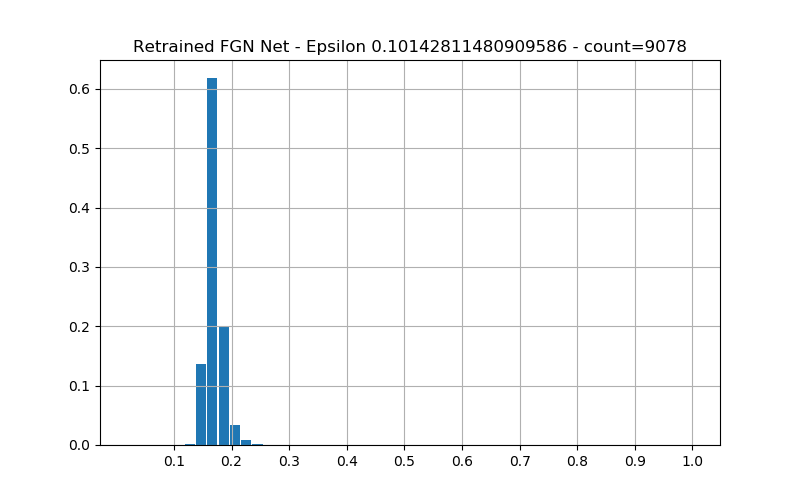

Statistical description of the predictions maximums
DescribeResult(nobs=9078, minmax=(0.10191386423421730866, 0.3425079984699272064), mean=0.16987559481904843105, variance=0.00020804462193004134301, skewness=1.8983759982984439367, kurtosis=10.8725759733505659985)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7171 prediction [0.03 0.12 0.14 0.16 0.07 0.16 0.08 0.12 0.06 0.07]
index 7123 prediction [0.03 0.11 0.13 0.17 0.07 0.15 0.06 0.11 0.1  0.07]
index 3136 prediction [0.03 0.12 0.14 0.16 0.07 0.16 0.07 0.13 0.06 0.07]
index 3039 prediction [0.04 0.11 0.13 0.16 0.07 0.14 0.07 0.1  0.1  0.08]
index 6806 prediction [0.03 0.12 0.14 0.16 0.07 0.17 0.09 0.11 0.06 0.06]


<IPython.core.display.Javascript object>


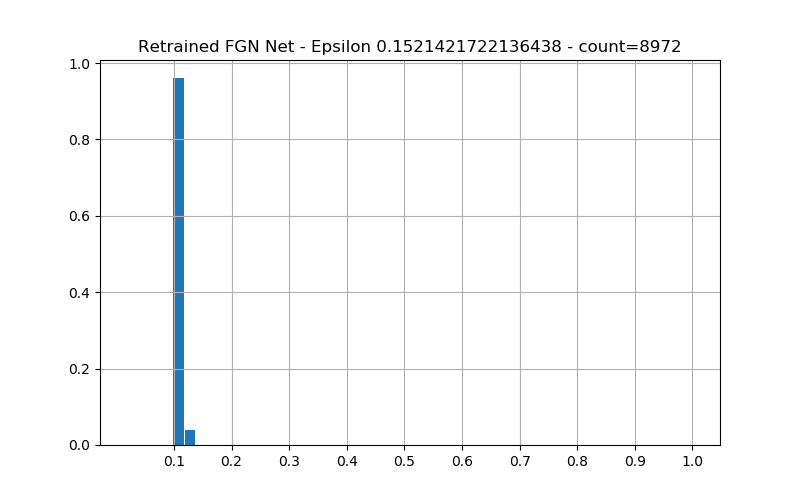

Statistical description of the predictions maximums
DescribeResult(nobs=8972, minmax=(0.10039972073944992284, 0.14258401631551242756), mean=0.11116860065118965444, variance=9.76935505957926168e-06, skewness=1.7901658570227803478, kurtosis=7.255158112869728294)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8322 prediction [0.07 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.11 0.09]
index 1747 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.11 0.09]
index 1799 prediction [0.07 0.11 0.11 0.12 0.09 0.12 0.11 0.09 0.1  0.09]
index 5005 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.11 0.09]
index 1199 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.11 0.09]


<IPython.core.display.Javascript object>


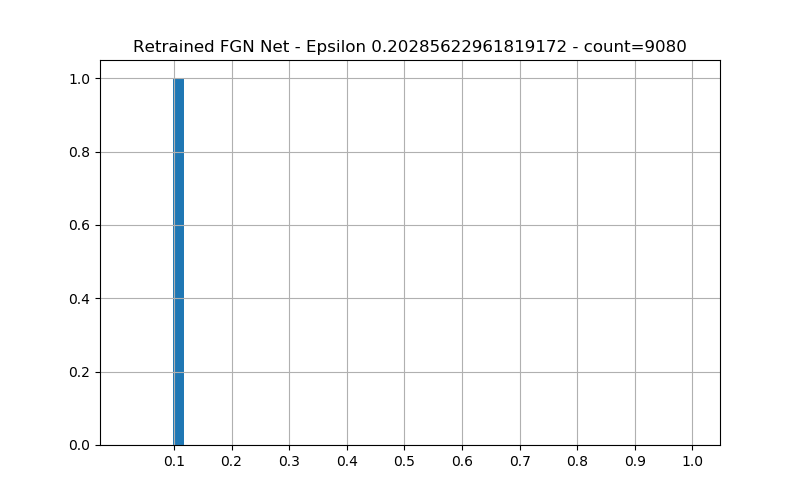

Statistical description of the predictions maximums
DescribeResult(nobs=9080, minmax=(0.10004368064186776231, 0.109273182574751720406), mean=0.10163402945508807051, variance=4.391840135426999996e-07, skewness=2.409947878951629924, kurtosis=12.763989008271355826)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5469 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2930 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4678 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6817 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3227 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


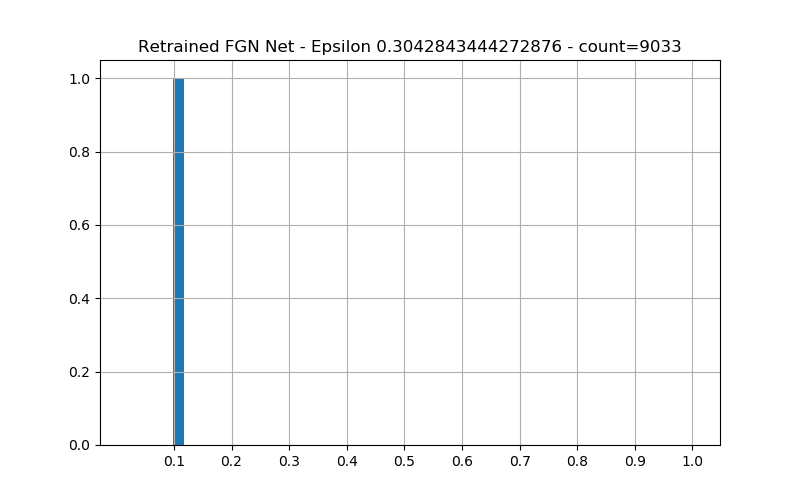

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.100000070116455921314, 0.100380815887842360964), mean=0.10001074034441461267, variance=2.1738722872688062772e-10, skewness=7.9672737651993043926, kurtosis=122.46539053092685732)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 1004 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1415 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4804 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7652 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3739 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


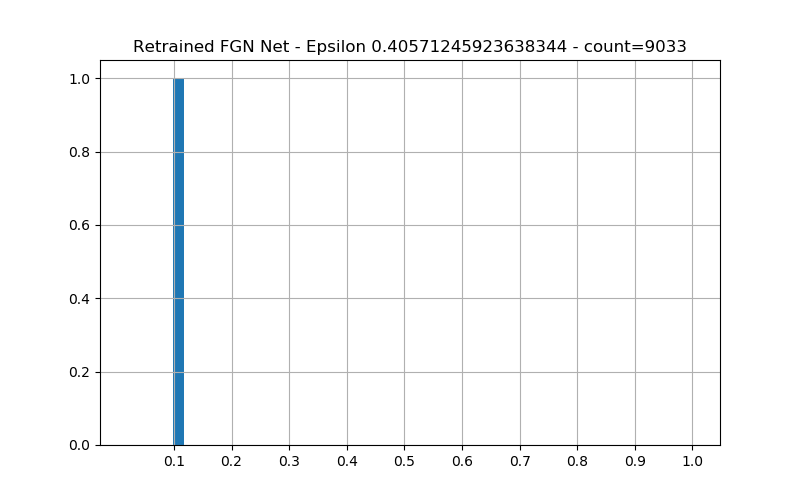

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000000095377442, 0.10000429226174288999), mean=0.10000001510058654355, variance=7.34544793997779617e-15, skewness=30.816683092155925298, kurtosis=1330.9410514963417654)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4464 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4242 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4413 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2738 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3470 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


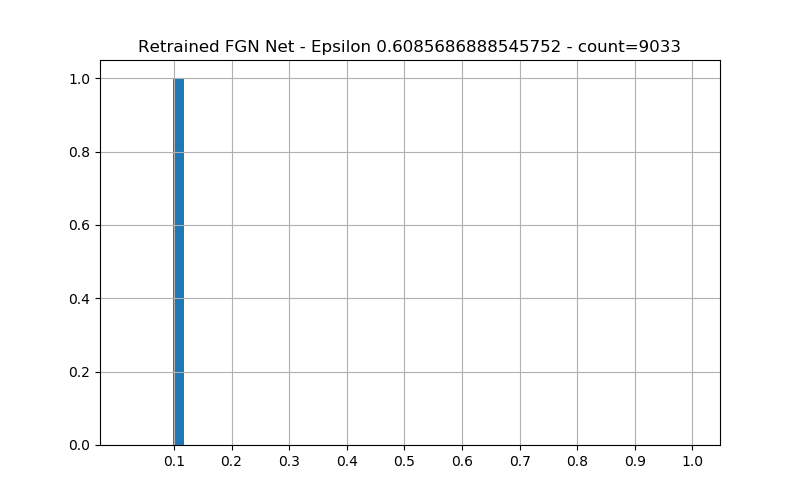

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.10000000001115301205), mean=0.10000000000000377527, variance=2.5963784496897960078e-26, skewness=63.465439003949319963, kurtosis=4169.7425352355909176)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 777 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8213 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3885 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1222 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5184 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


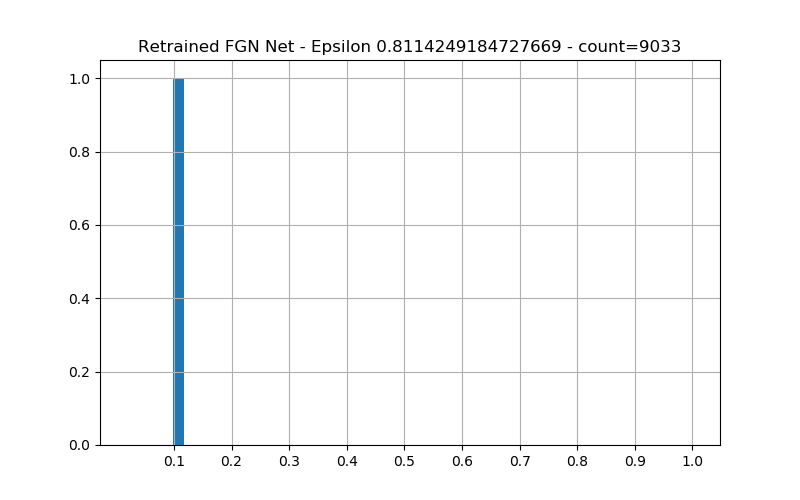

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.10000000000000000017), mean=0.10000000000000000002, variance=4.1709299024545587793e-40, skewness=-0.9231018040550740745, kurtosis=-1.5920072165365506051)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6103 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7223 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6071 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8562 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8093 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


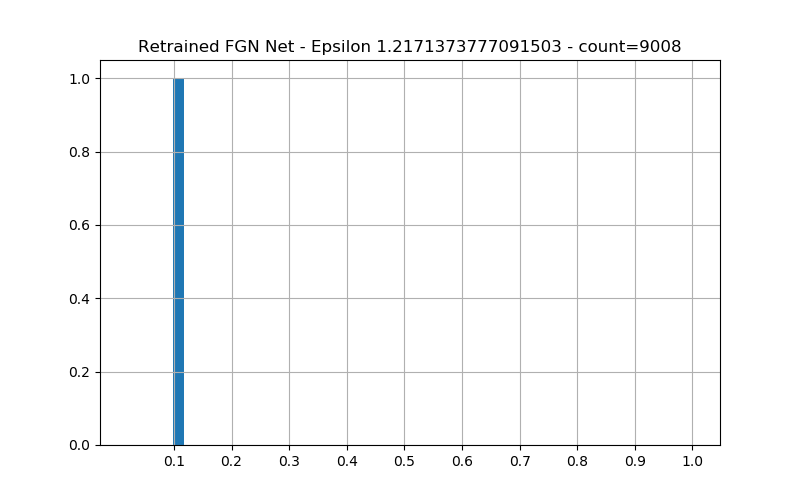

Statistical description of the predictions maximums
DescribeResult(nobs=9008, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.836913843435516451e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2923 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7392 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1018 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2330 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4602 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


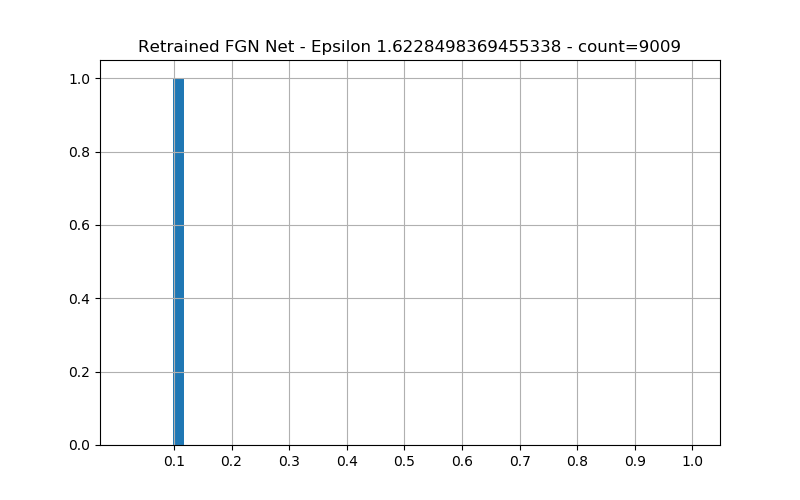

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3187 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4734 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2140 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 899 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8651 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


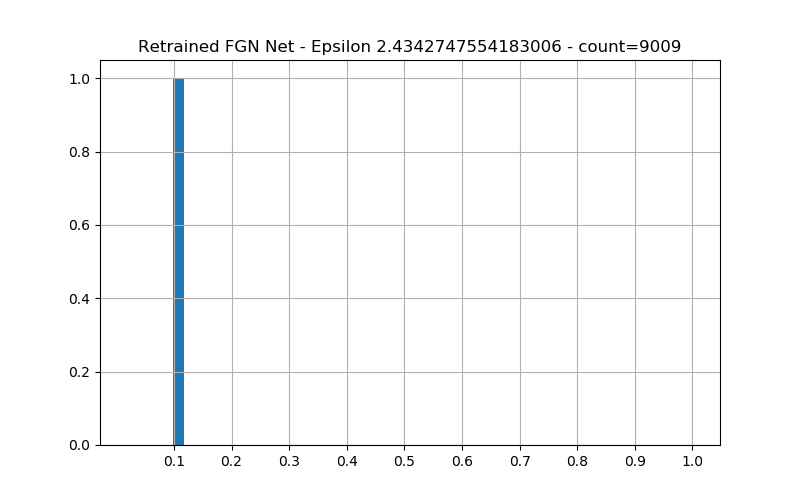

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8208 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4628 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2270 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4752 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3476 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


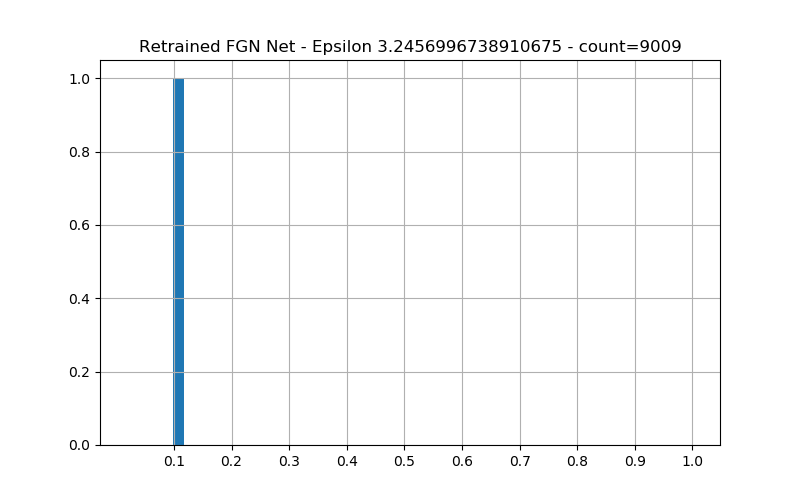

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6164 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8003 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7367 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4815 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8328 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [35]:
# rerun the ret_quick_fgn model on adv examples
for i, ret_quick_fgn_raw_images in enumerate(ret_quick_fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(ret_quick_fgn_raw_images))
    t = 'Retrained FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(ret_quick_fgn_model, dl, title=t, verbose=True)

<IPython.core.display.Javascript object>


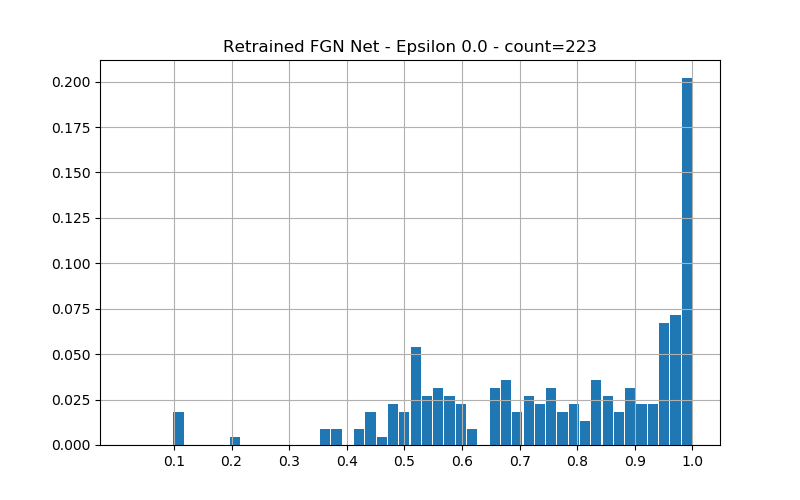

Statistical description of the predictions maximums
DescribeResult(nobs=223, minmax=(0.101041420926519028744, 0.9999292554688378194), mean=0.7694593098247338963, variance=0.0453335566210167978, skewness=-0.77872025086697758, kurtosis=0.014876547107085710689)

percentage of confident predictions (>=0.5): 0.8968609865470852

Sample predictions
index 122 prediction [0.36 0.   0.01 0.05 0.   0.   0.   0.   0.58 0.  ]
index 203 prediction [0.   0.01 0.06 0.03 0.   0.   0.   0.84 0.05 0.01]
index 73 prediction [0.   0.01 0.1  0.69 0.   0.   0.   0.07 0.14 0.  ]
index 184 prediction [0.11 0.   0.   0.   0.   0.   0.89 0.   0.   0.  ]
index 14 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<IPython.core.display.Javascript object>


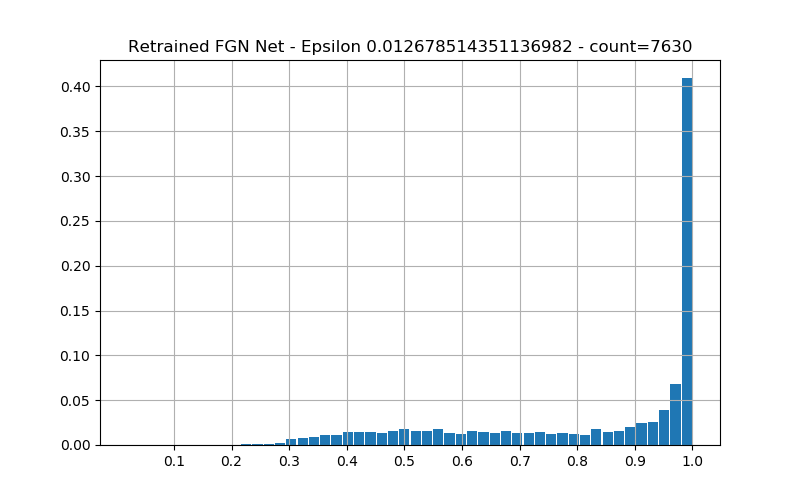

Statistical description of the predictions maximums
DescribeResult(nobs=7630, minmax=(0.10106553969347717307, 0.9998047946998601652), mean=0.82104454396075038575, variance=0.04734424638164671915, skewness=-0.955749349300027972, kurtosis=-0.51527430387850351704)

percentage of confident predictions (>=0.5): 0.8665792922673656

Sample predictions
index 1847 prediction [0.01 0.   0.31 0.01 0.02 0.   0.3  0.33 0.   0.  ]
index 3795 prediction [0.   0.06 0.16 0.   0.01 0.01 0.02 0.71 0.   0.03]
index 6548 prediction [0.26 0.   0.   0.07 0.   0.27 0.   0.02 0.36 0.02]
index 6747 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.99 0.  ]
index 4529 prediction [0.   0.02 0.09 0.02 0.   0.76 0.03 0.07 0.   0.01]


<IPython.core.display.Javascript object>


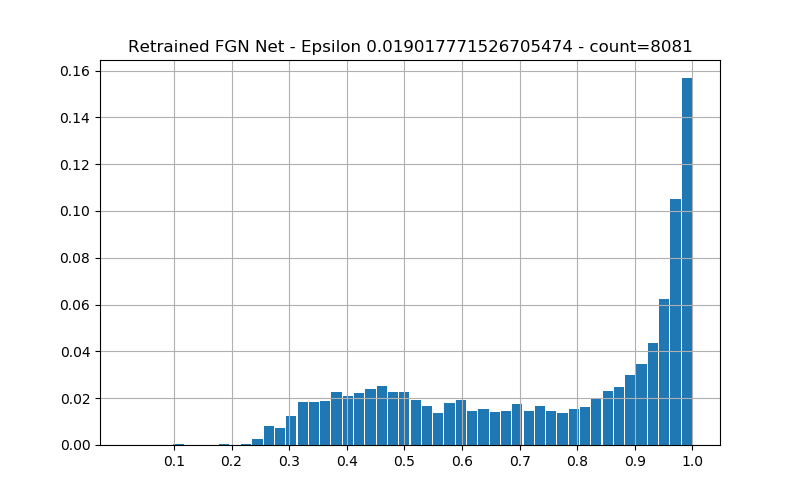

Statistical description of the predictions maximums
DescribeResult(nobs=8081, minmax=(0.10104858275774970747, 0.9997469366029620215), mean=0.7388977170838817612, variance=0.055924503593964903653, skewness=-0.49671886526087960298, kurtosis=-1.2399596665840383326)

percentage of confident predictions (>=0.5): 0.7647568370251207

Sample predictions
index 1132 prediction [0.01 0.01 0.38 0.02 0.   0.06 0.45 0.07 0.   0.  ]
index 4456 prediction [0.   0.   0.02 0.05 0.   0.   0.   0.   0.92 0.  ]
index 1264 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.98 0.  ]
index 6302 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.98 0.  ]
index 5499 prediction [0.04 0.05 0.1  0.2  0.   0.22 0.01 0.15 0.2  0.02]


<IPython.core.display.Javascript object>


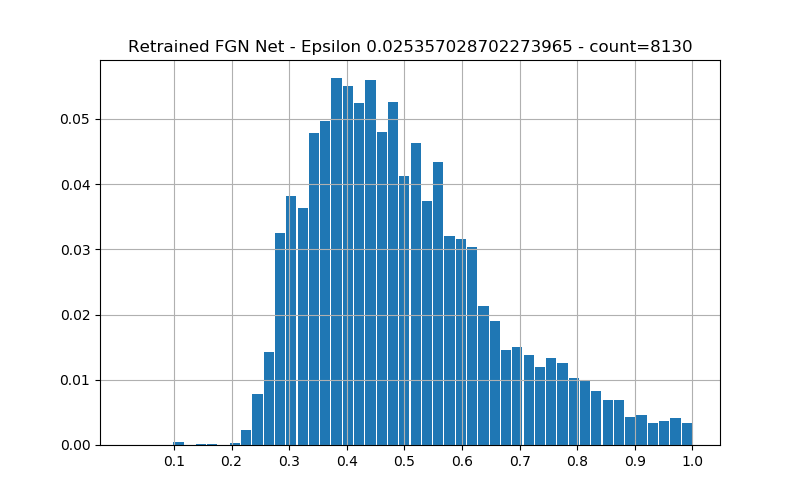

Statistical description of the predictions maximums
DescribeResult(nobs=8130, minmax=(0.10101314777851345562, 0.99932388510684409144), mean=0.4984838465305298441, variance=0.025007326239059767007, skewness=0.7960016551414510301, kurtosis=0.23385121383248259658)

percentage of confident predictions (>=0.5): 0.4280442804428044

Sample predictions
index 3328 prediction [0.   0.02 0.03 0.18 0.   0.07 0.   0.03 0.67 0.01]
index 5479 prediction [0.   0.03 0.17 0.74 0.   0.07 0.   0.   0.   0.  ]
index 3858 prediction [0.   0.01 0.17 0.03 0.02 0.17 0.23 0.37 0.   0.  ]
index 7607 prediction [0.03 0.03 0.09 0.28 0.   0.28 0.   0.13 0.12 0.04]
index 3298 prediction [0.   0.01 0.06 0.31 0.   0.01 0.   0.07 0.48 0.05]


<IPython.core.display.Javascript object>


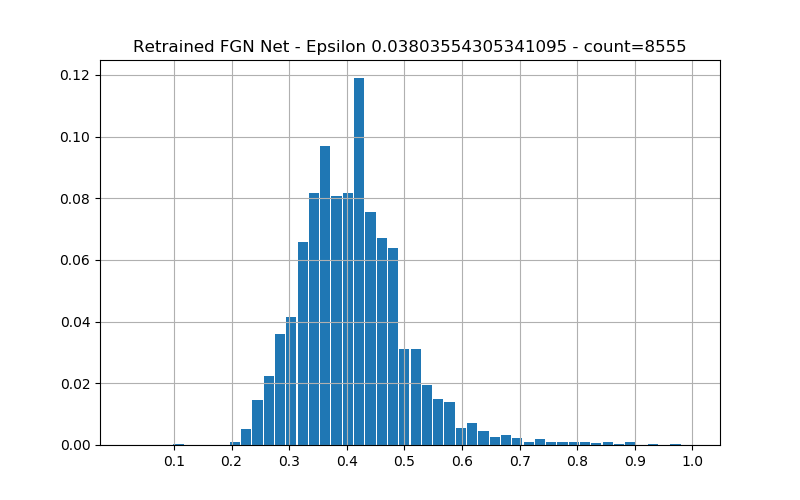

Statistical description of the predictions maximums
DescribeResult(nobs=8555, minmax=(0.100895171499419724576, 0.97135259321829648467), mean=0.41040001169688443476, variance=0.0085288590701913802435, skewness=1.0992424775197804195, kurtosis=3.3016747154501973052)

percentage of confident predictions (>=0.5): 0.13080070134424313

Sample predictions
index 690 prediction [0.   0.07 0.24 0.04 0.01 0.13 0.13 0.35 0.   0.02]
index 2450 prediction [0.   0.09 0.17 0.1  0.01 0.21 0.09 0.29 0.   0.03]
index 1688 prediction [0.   0.08 0.08 0.23 0.01 0.14 0.01 0.4  0.01 0.04]
index 4303 prediction [0.   0.04 0.1  0.32 0.01 0.14 0.   0.33 0.02 0.03]
index 7253 prediction [0.   0.04 0.09 0.32 0.   0.1  0.   0.39 0.02 0.04]


<IPython.core.display.Javascript object>


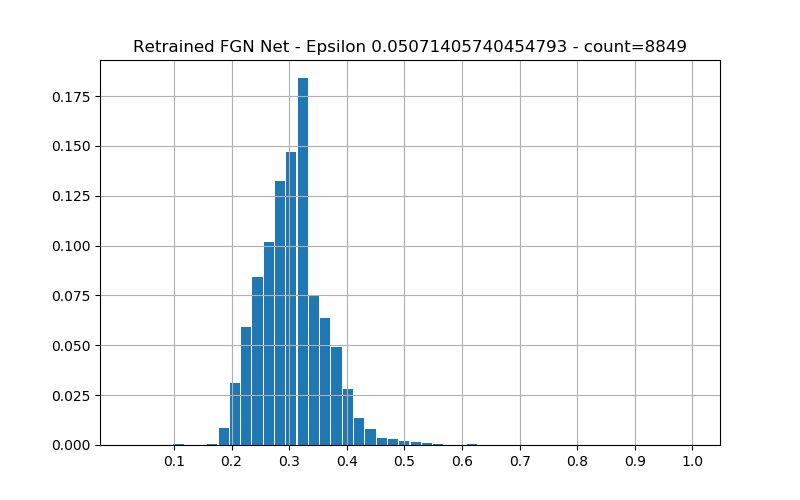

Statistical description of the predictions maximums
DescribeResult(nobs=8849, minmax=(0.10073487305407625461, 0.79872868898987569317), mean=0.30557769763458992232, variance=0.0031909566696753687015, skewness=0.7701370035066712354, kurtosis=2.8441623925074157363)

percentage of confident predictions (>=0.5): 0.005424341733529212

Sample predictions
index 5403 prediction [0.01 0.06 0.1  0.21 0.04 0.19 0.03 0.3  0.01 0.05]
index 938 prediction [0.01 0.11 0.14 0.17 0.03 0.14 0.03 0.3  0.02 0.05]
index 6527 prediction [0.01 0.09 0.14 0.18 0.02 0.12 0.02 0.38 0.01 0.03]
index 442 prediction [0.01 0.09 0.15 0.19 0.03 0.14 0.04 0.27 0.02 0.05]
index 6675 prediction [0.01 0.1  0.14 0.19 0.03 0.14 0.03 0.3  0.02 0.04]


<IPython.core.display.Javascript object>


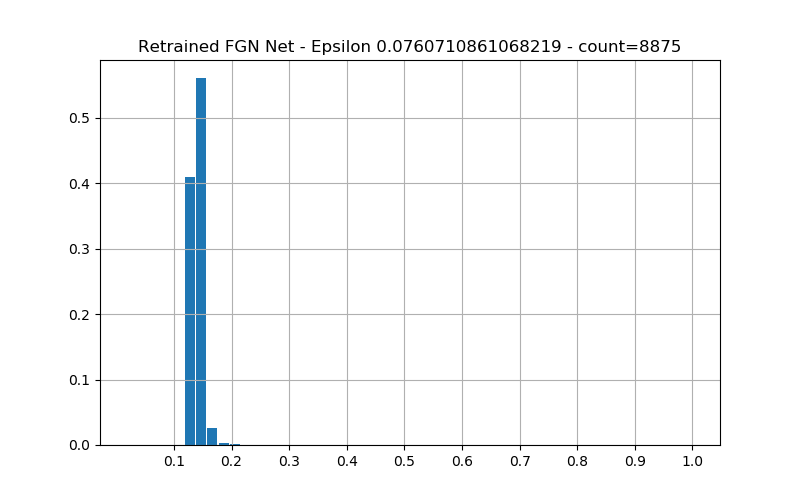

Statistical description of the predictions maximums
DescribeResult(nobs=8875, minmax=(0.10039699517535625088, 0.21795389234596029262), mean=0.14072238782707641034, variance=6.0447894699217583692e-05, skewness=1.8912496410194018883, kurtosis=9.352895510583258869)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8318 prediction [0.03 0.11 0.14 0.13 0.07 0.15 0.12 0.12 0.06 0.06]
index 8643 prediction [0.03 0.12 0.14 0.13 0.06 0.15 0.13 0.12 0.06 0.06]
index 1947 prediction [0.03 0.11 0.14 0.13 0.07 0.15 0.12 0.12 0.05 0.06]
index 7650 prediction [0.03 0.12 0.14 0.14 0.06 0.15 0.12 0.12 0.05 0.06]
index 6443 prediction [0.03 0.12 0.15 0.13 0.06 0.15 0.13 0.12 0.05 0.06]


<IPython.core.display.Javascript object>


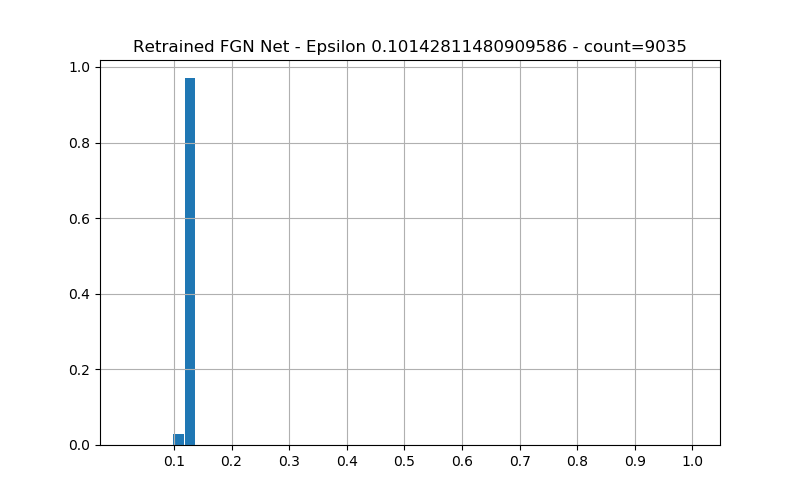

Statistical description of the predictions maximums
DescribeResult(nobs=9035, minmax=(0.10015959679040828988, 0.139560191873836315), mean=0.123394386282180362085, variance=9.3915541519804004975e-06, skewness=-0.16967327811318372176, kurtosis=1.217747185720414081)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3389 prediction [0.07 0.11 0.11 0.11 0.1  0.11 0.12 0.09 0.1  0.09]
index 834 prediction [0.06 0.11 0.12 0.11 0.09 0.11 0.13 0.09 0.1  0.08]
index 5711 prediction [0.07 0.11 0.11 0.11 0.09 0.11 0.12 0.09 0.1  0.08]
index 6178 prediction [0.07 0.11 0.11 0.11 0.09 0.11 0.12 0.09 0.1  0.08]
index 4794 prediction [0.07 0.11 0.11 0.11 0.09 0.11 0.12 0.09 0.1  0.08]


<IPython.core.display.Javascript object>


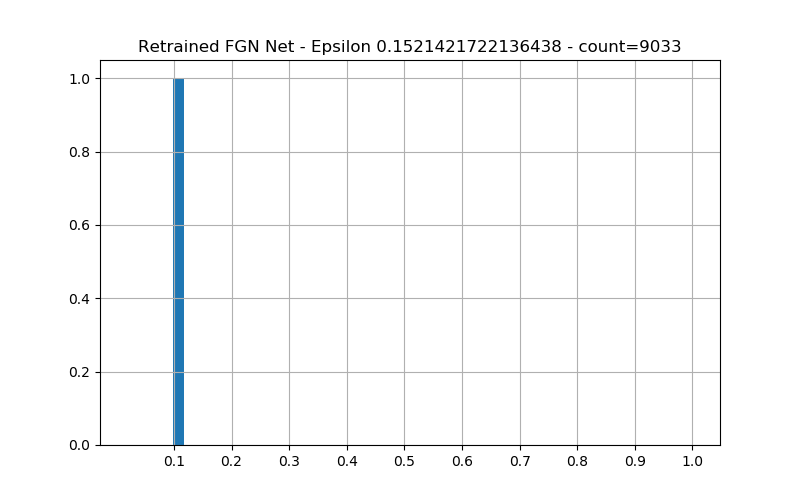

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10001062855150480491, 0.115074501706791761754), mean=0.102488583156853240936, variance=1.7163679566032888264e-06, skewness=2.2762034712557607293, kurtosis=9.311530582460269863)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8044 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2602 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3491 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7040 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 390 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


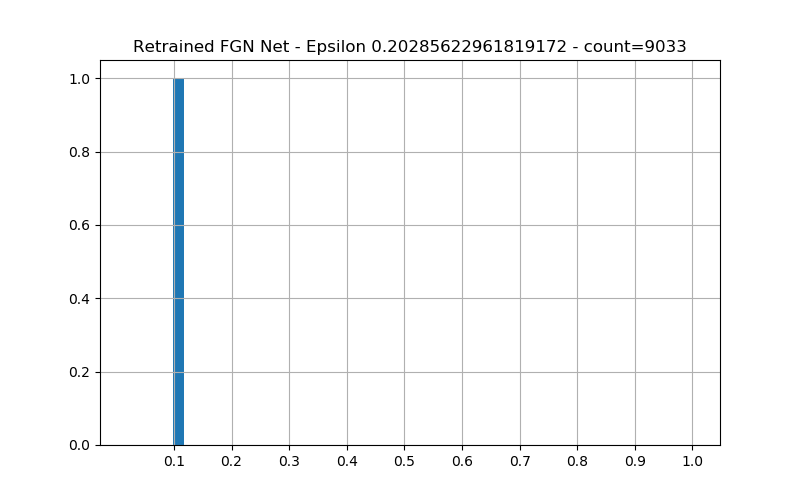

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000021738606056951, 0.10219193349151745659), mean=0.10008813711404330368, variance=1.1791299267636669962e-08, skewness=5.878437208420479249, kurtosis=59.93979423228995717)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4903 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3417 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7092 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3559 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8954 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


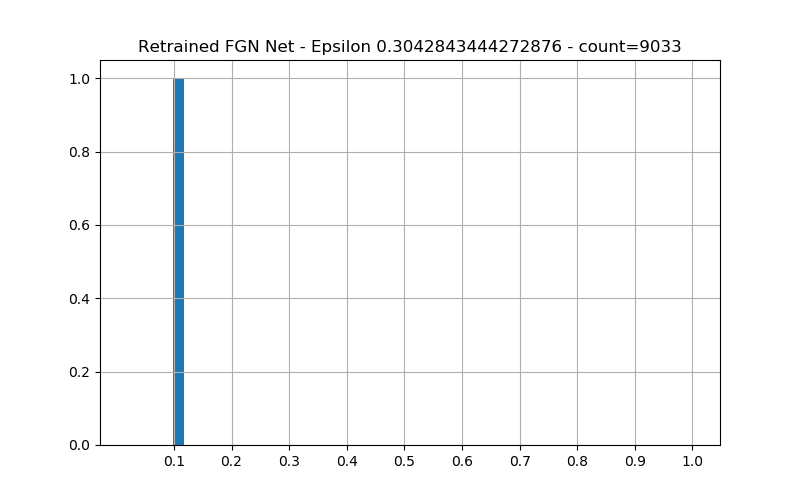

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000000082077969, 0.10000682718092193649), mean=0.10000001694377935802, variance=1.6672062705646624099e-14, skewness=29.194406746548788017, kurtosis=1204.37621398036035)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3047 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8641 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6025 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 848 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5952 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


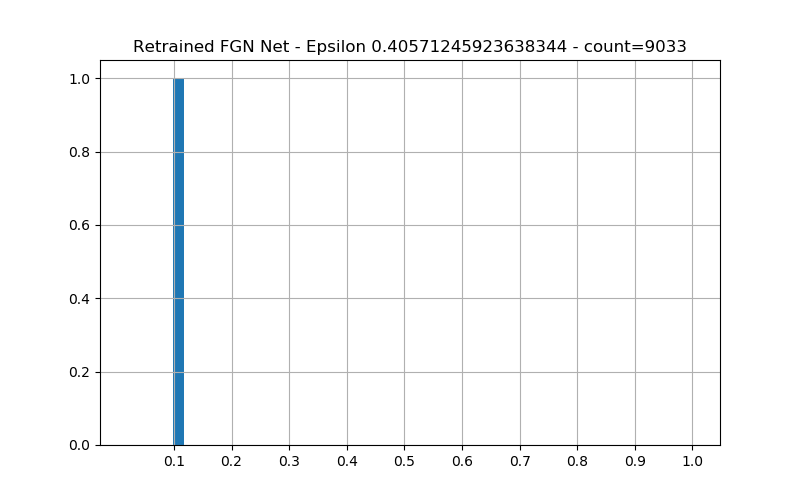

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.10000000207956738666), mean=0.10000000000093146587, variance=7.130052542263889046e-22, skewness=61.804709664815856617, kurtosis=4410.030606046760798)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4559 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 556 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 657 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7519 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5127 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


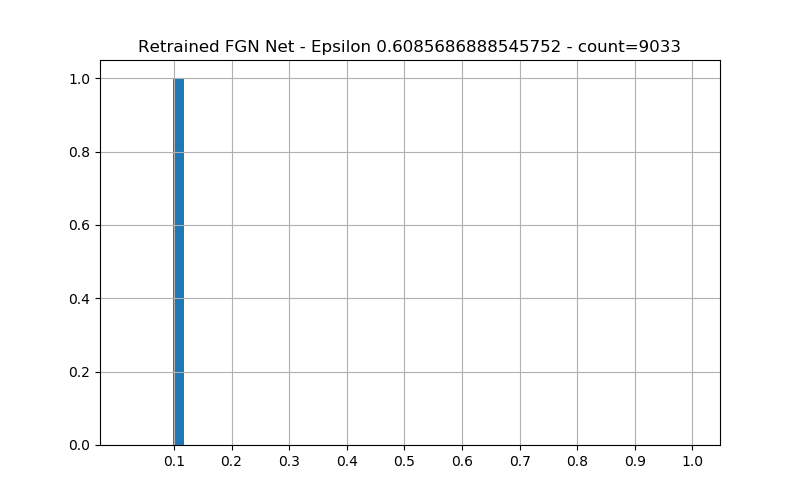

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.10000000000000000019), mean=0.10000000000000000002, variance=4.1638632871058205274e-40, skewness=-0.9252378329646726508, kurtosis=-1.4890192838466673217)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4296 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4623 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2300 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5270 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 990 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


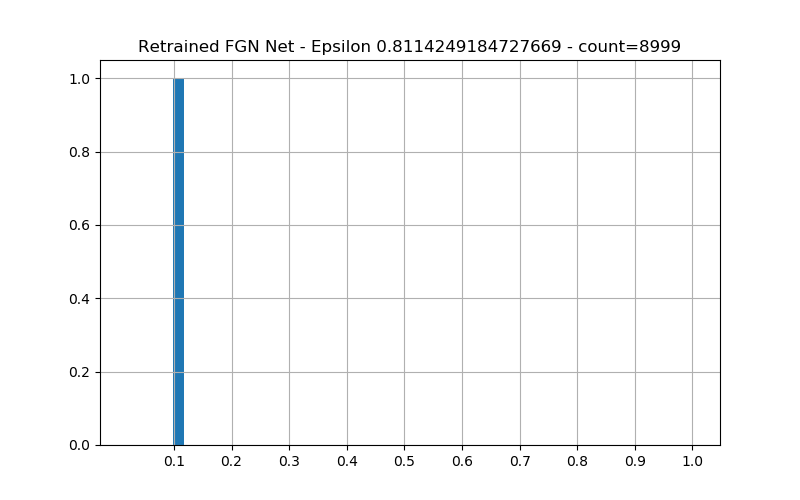

Statistical description of the predictions maximums
DescribeResult(nobs=8999, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369140474011178324e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 738 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6157 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4362 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7001 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2964 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


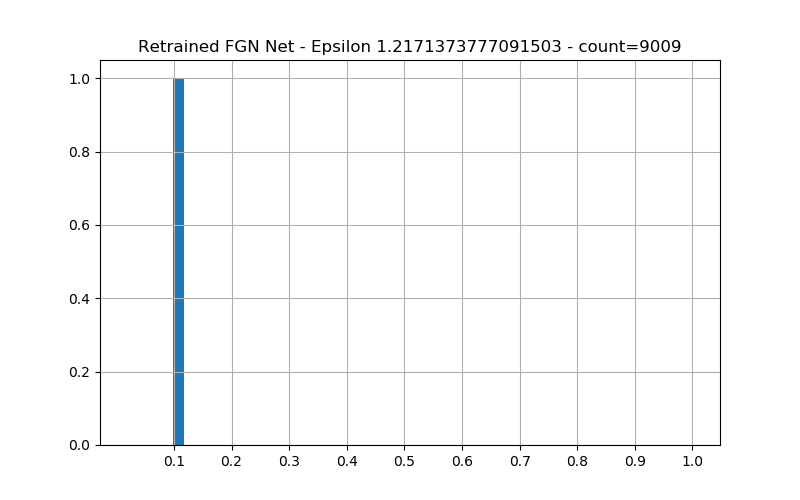

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4963 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5179 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5632 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1900 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7998 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


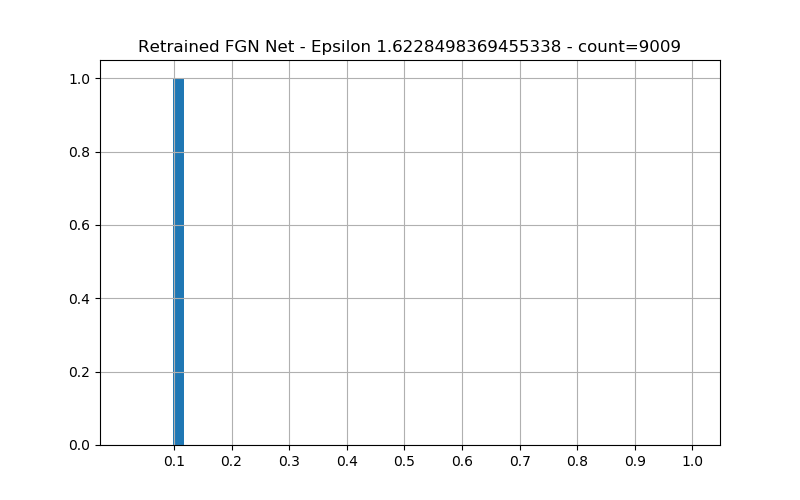

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7888 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7673 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2218 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5724 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2031 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


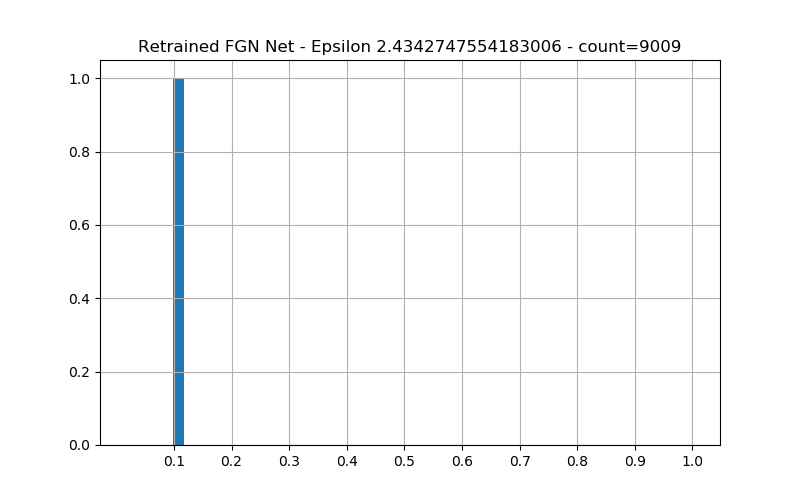

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5133 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1594 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3647 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1333 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4491 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


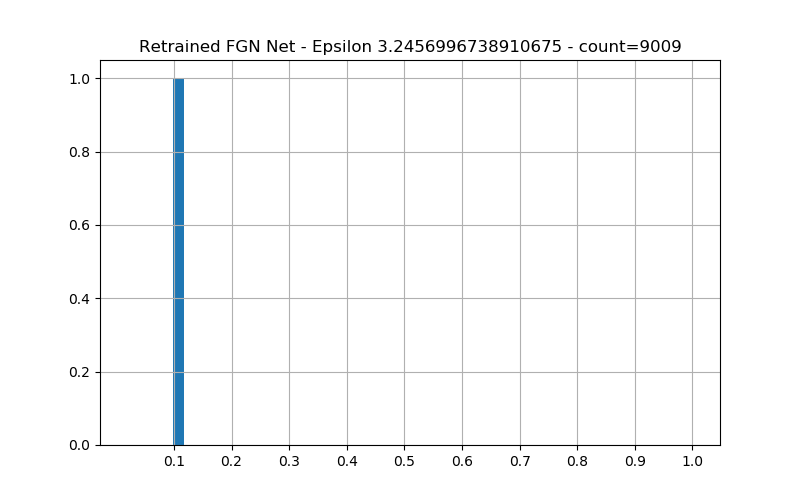

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 867 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8582 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8892 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4242 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6191 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [36]:
# rerun the ret_fgn model on adv examples
for i, ret_fgn_raw_images in enumerate(ret_fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(ret_fgn_raw_images))
    t = 'Retrained FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(ret_fgn_model, dl, title=t, verbose=True)

In [37]:
ret_fgn_f_model(ret_fgn_raw[1][0])

tensor([[-0.6968, -1.7009, -1.0296,  3.1191, -2.5806,  0.6143, -0.2894, -4.0053,
          9.3113, -1.6526]])

In [38]:
labels[0]

tensor(3)

In [39]:
ret_fgn_adv_success[1][0]

tensor(True)

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


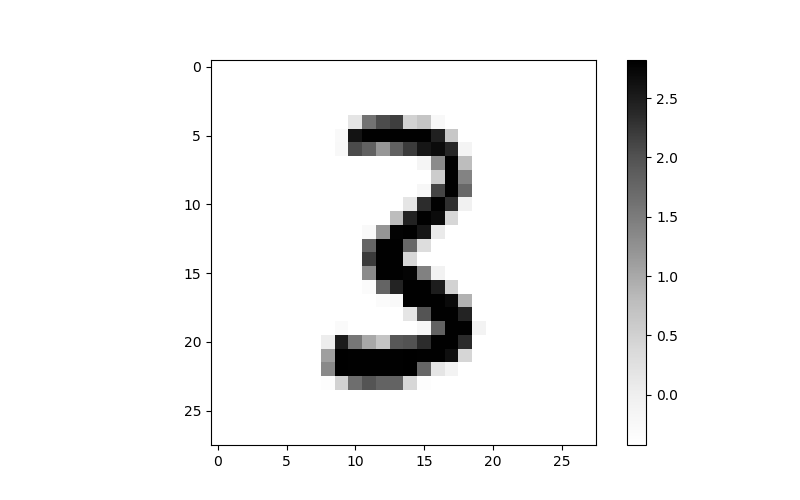

In [40]:
# original image
plt.imshow(images[0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


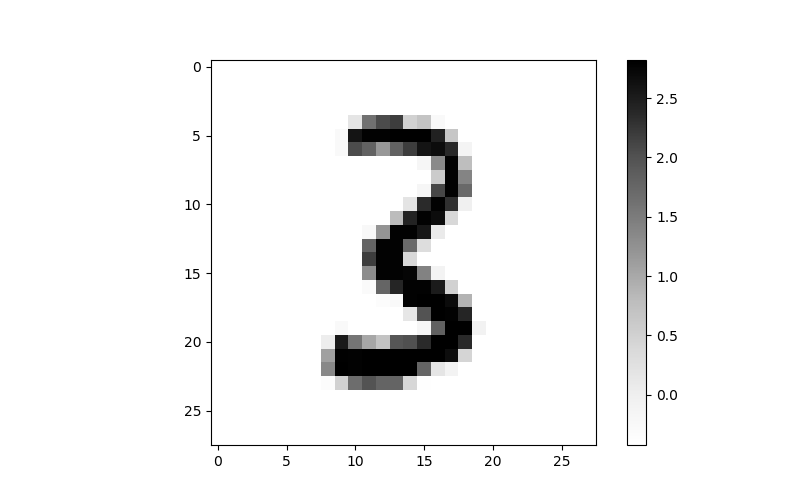

In [41]:
# adversarial image
plt.imshow(ret_fgn_raw[1][0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


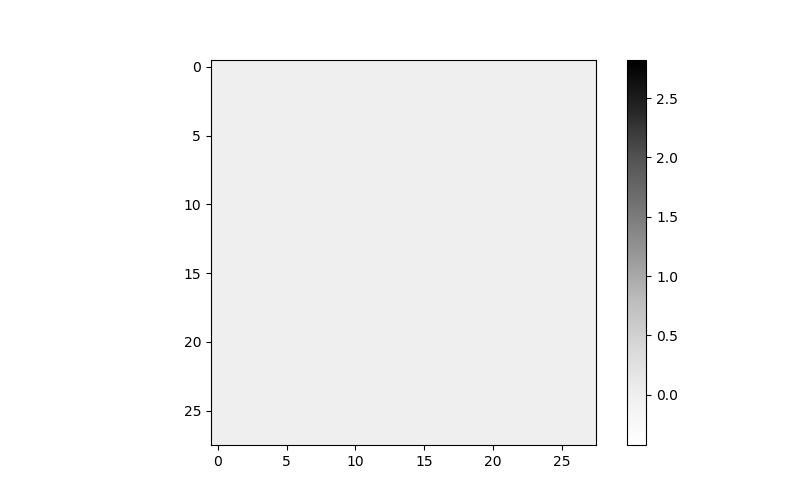

In [42]:
# noise
plt.imshow(images[0].cpu().numpy()-ret_fgn_raw[0][0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


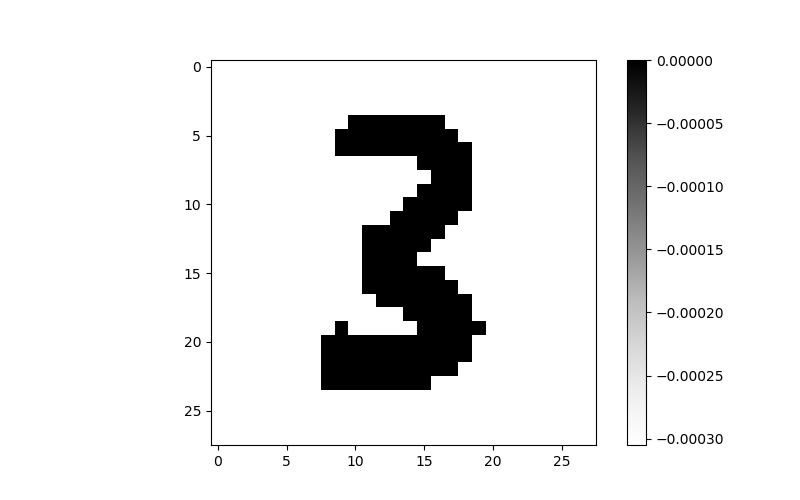

In [43]:
# noise with exagerated contrast
plt.imshow(images[0].cpu().numpy()-ret_fgn_raw[0][0].cpu().numpy(), cmap='Greys')
plt.colorbar()
plt.show()

In [44]:
# compare prediction confidences 

In [45]:
names = ['classic', 'fgn', 'retrained']
al = ['right', 'mid', 'left']

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


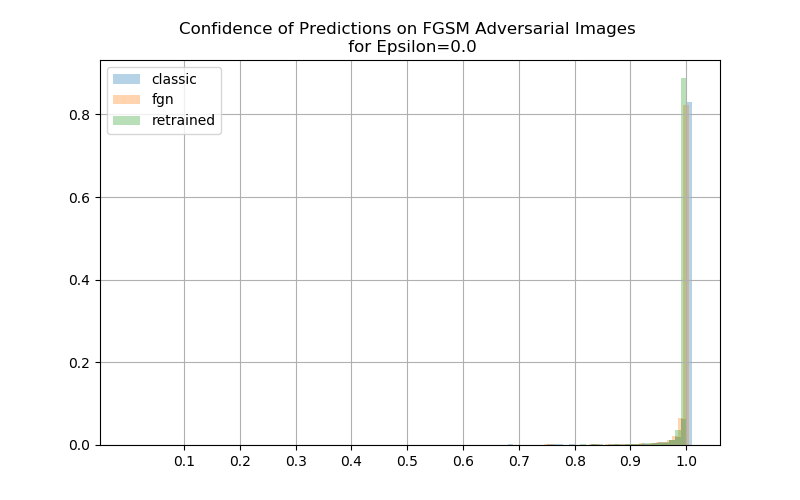

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


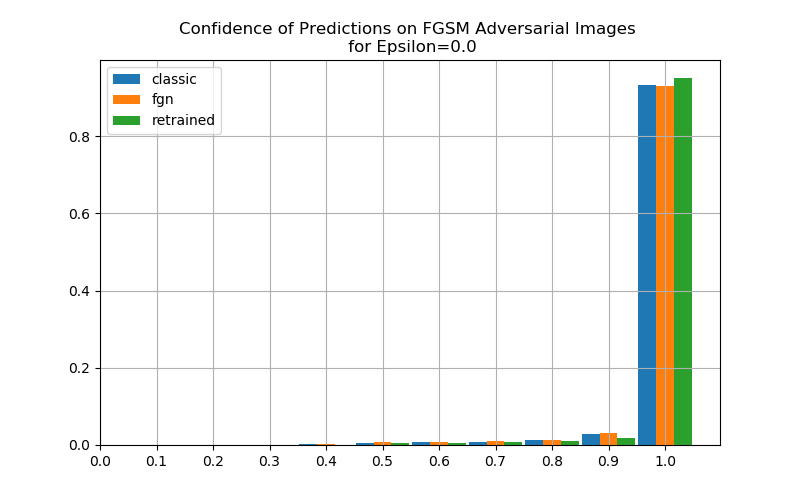

<IPython.core.display.Javascript object>


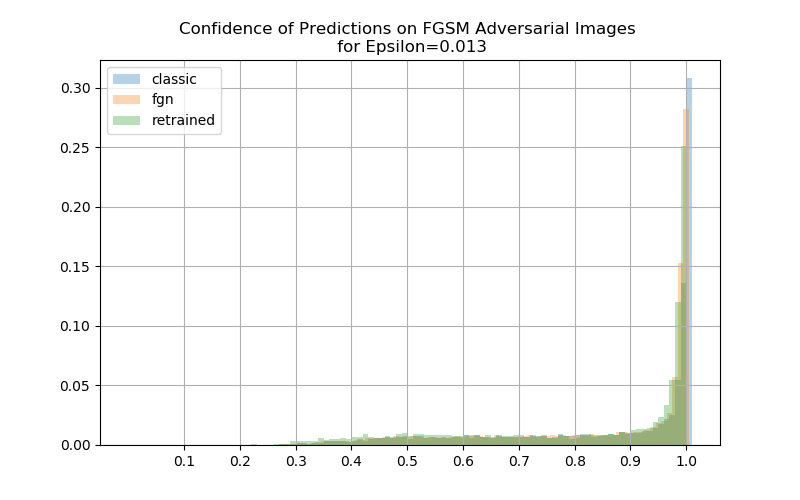

<IPython.core.display.Javascript object>


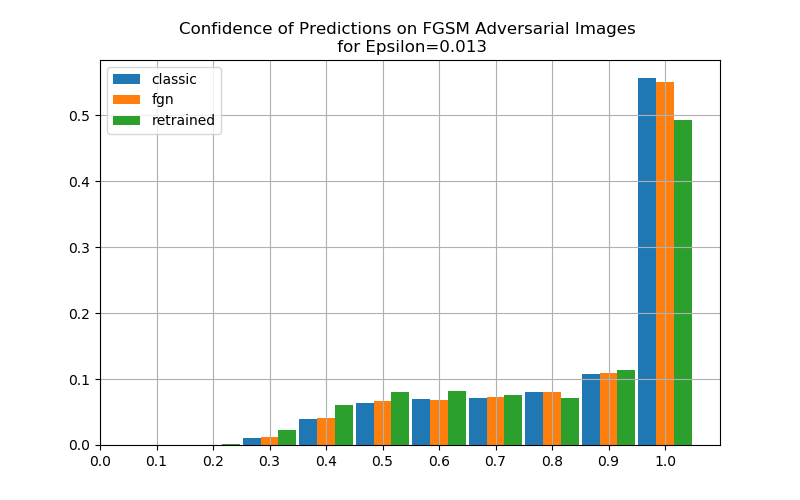

<IPython.core.display.Javascript object>


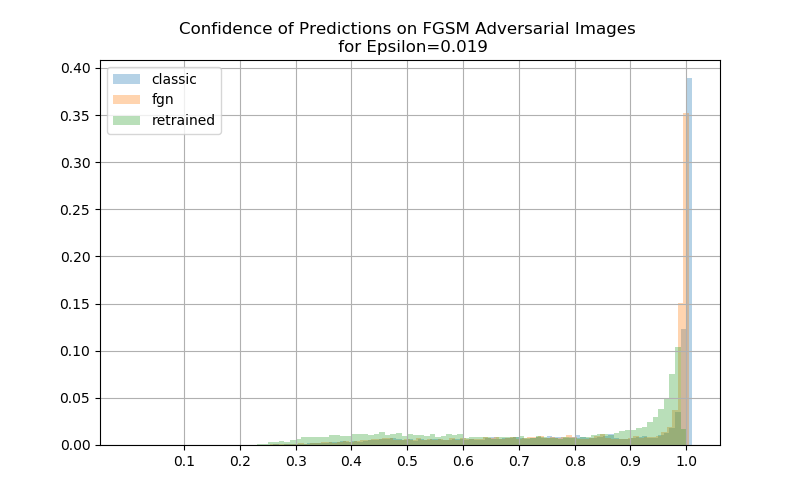

<IPython.core.display.Javascript object>


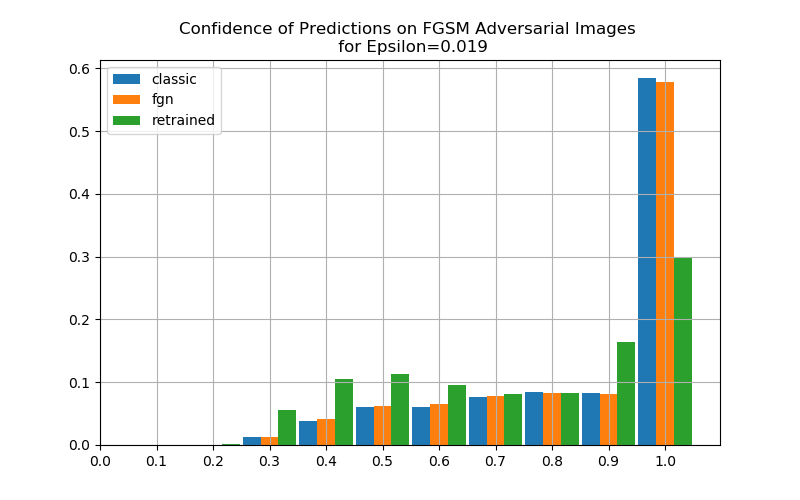

<IPython.core.display.Javascript object>


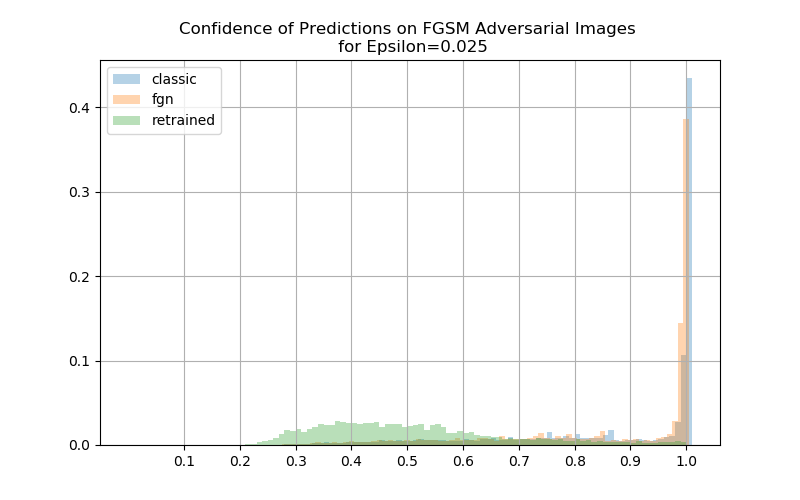

<IPython.core.display.Javascript object>


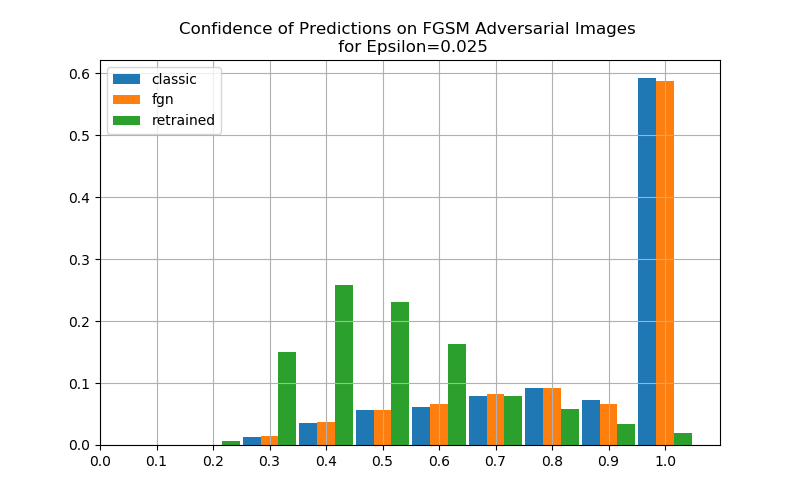

<IPython.core.display.Javascript object>


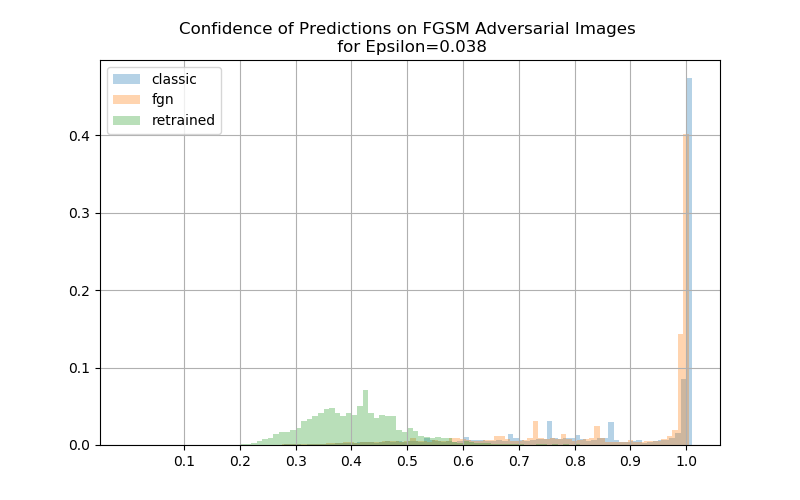

<IPython.core.display.Javascript object>


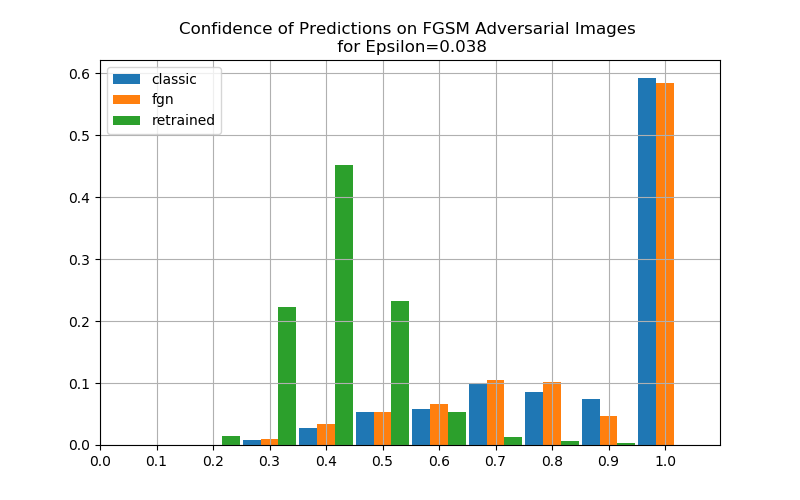

<IPython.core.display.Javascript object>


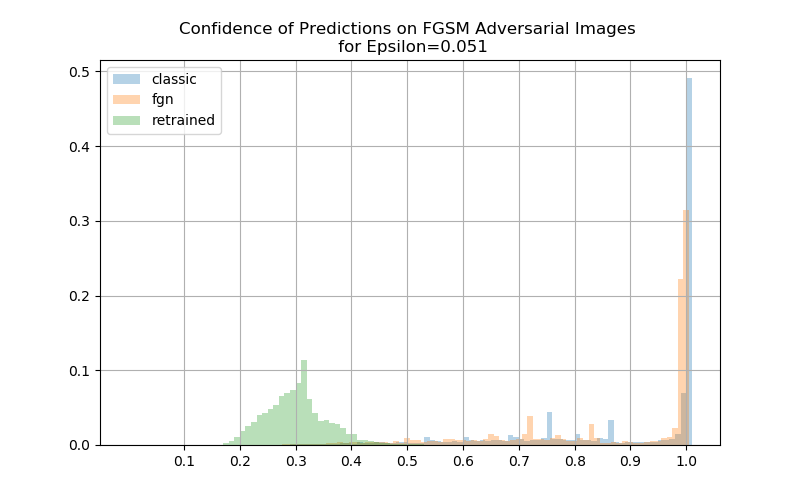

<IPython.core.display.Javascript object>


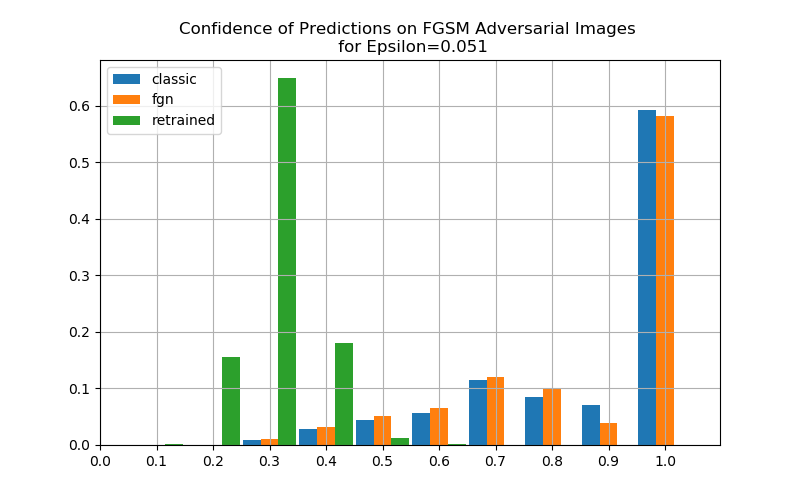

<IPython.core.display.Javascript object>


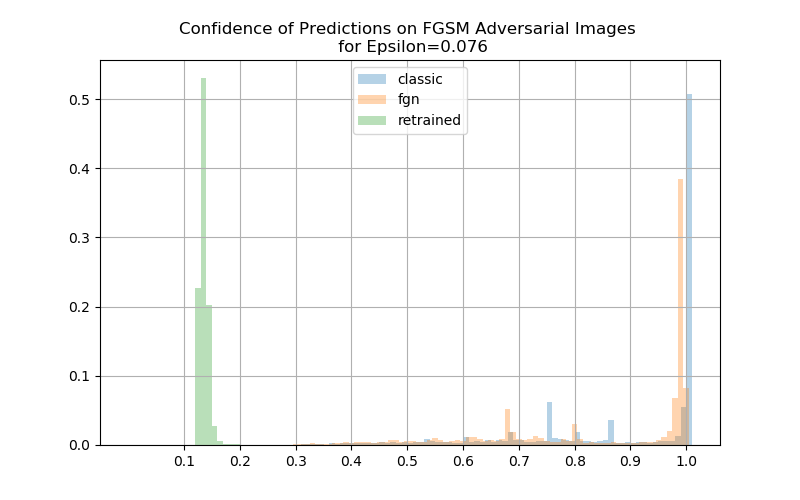

<IPython.core.display.Javascript object>


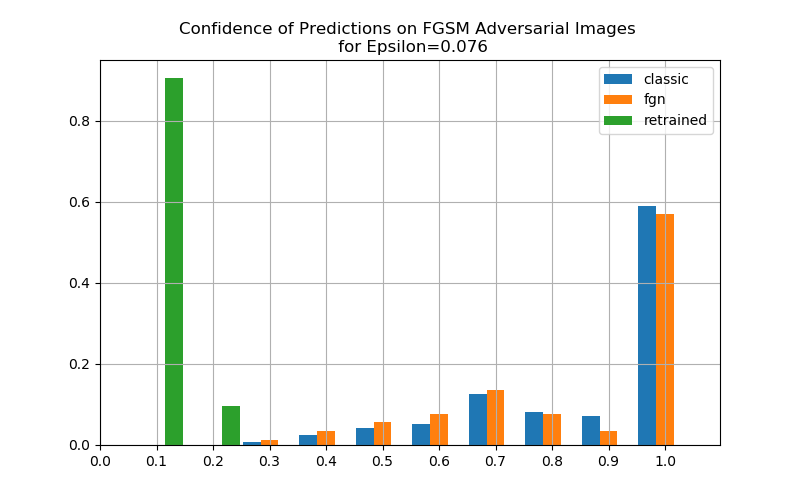

<IPython.core.display.Javascript object>


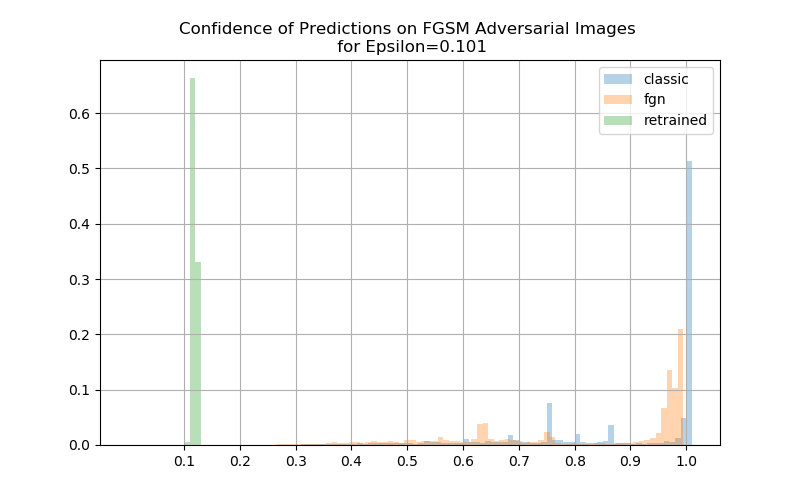

<IPython.core.display.Javascript object>


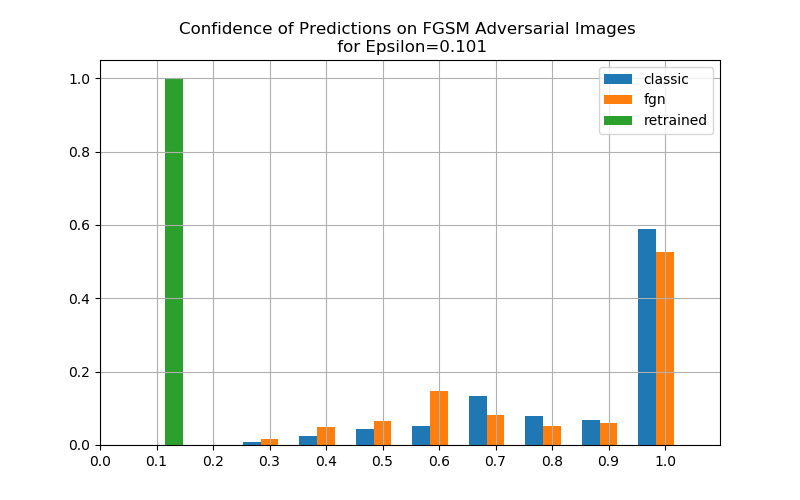

<IPython.core.display.Javascript object>


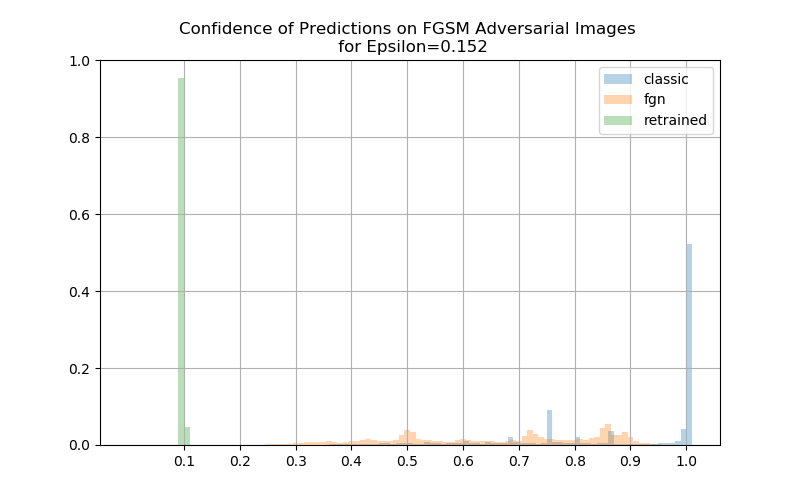

<IPython.core.display.Javascript object>


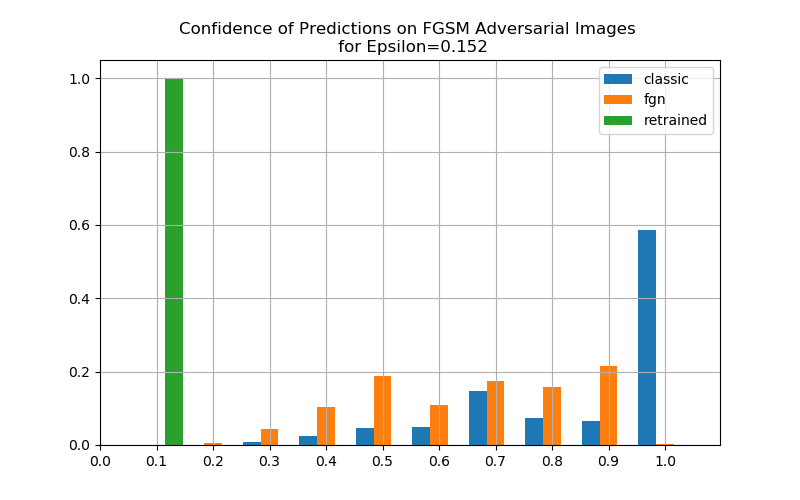

<IPython.core.display.Javascript object>


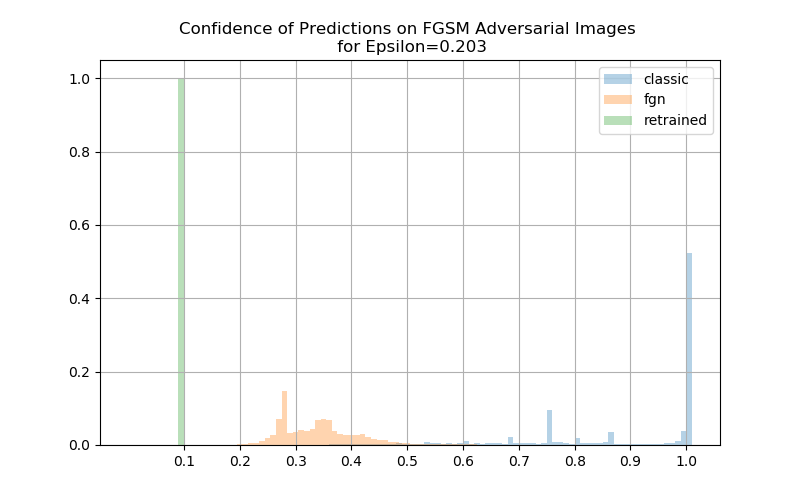

<IPython.core.display.Javascript object>


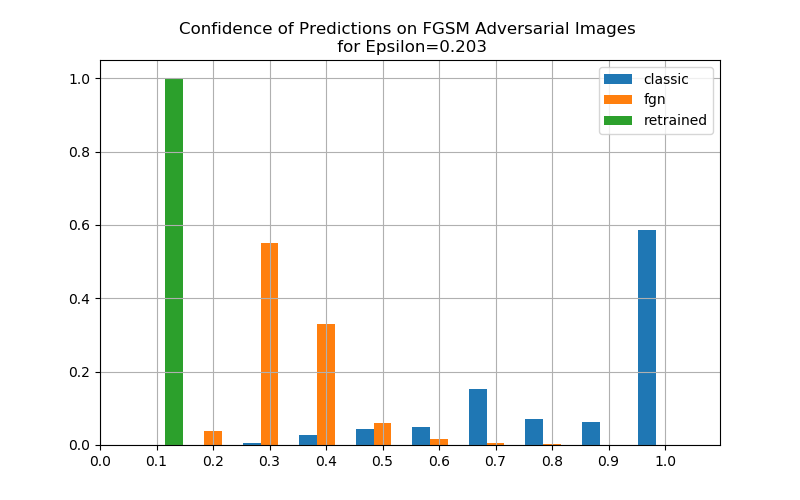

<IPython.core.display.Javascript object>


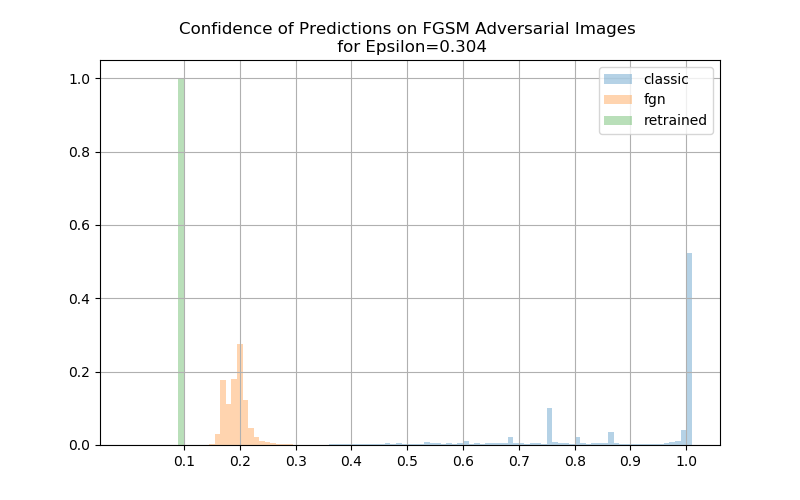

<IPython.core.display.Javascript object>


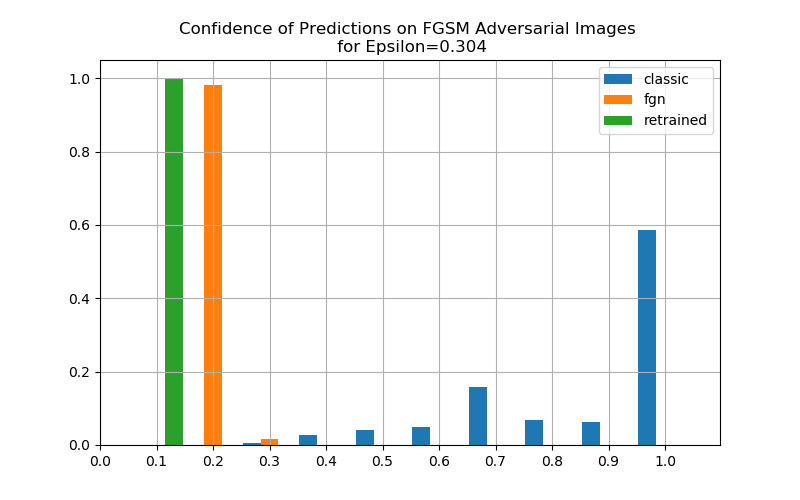

<IPython.core.display.Javascript object>


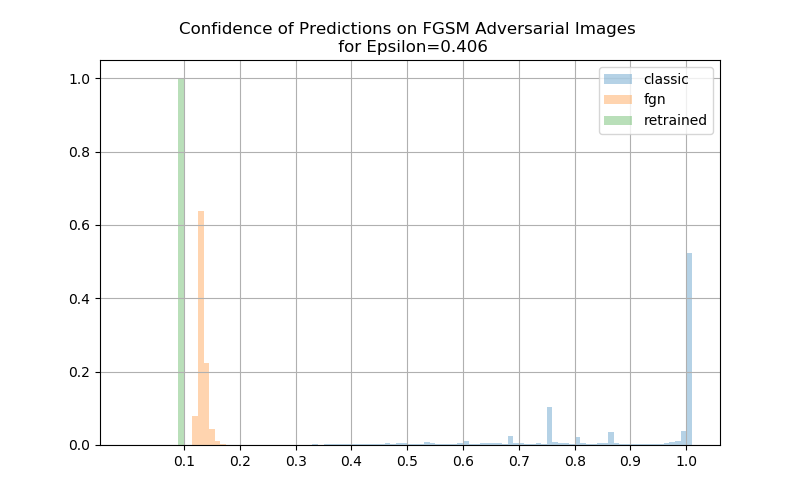

<IPython.core.display.Javascript object>


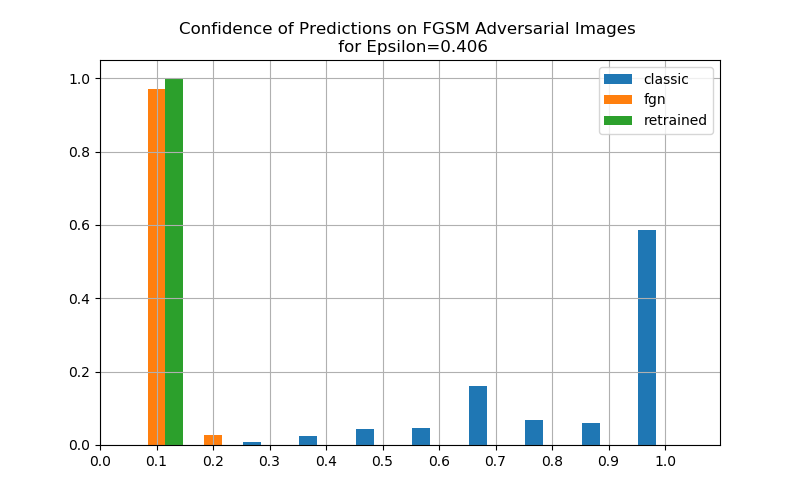

<IPython.core.display.Javascript object>


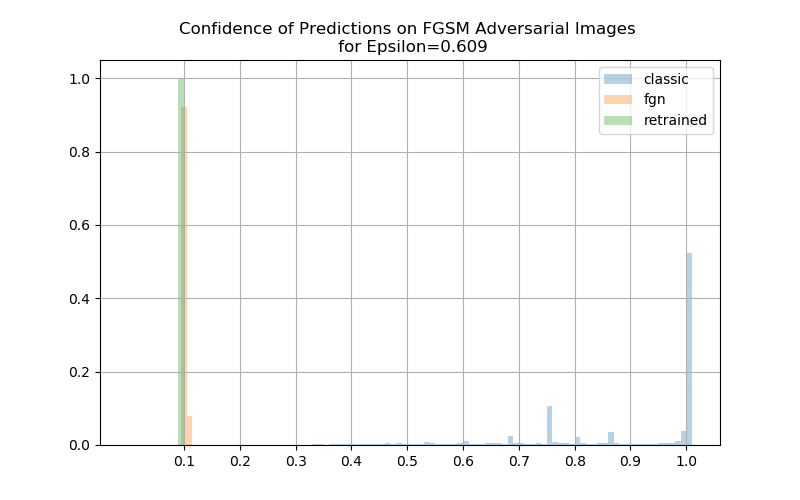

<IPython.core.display.Javascript object>


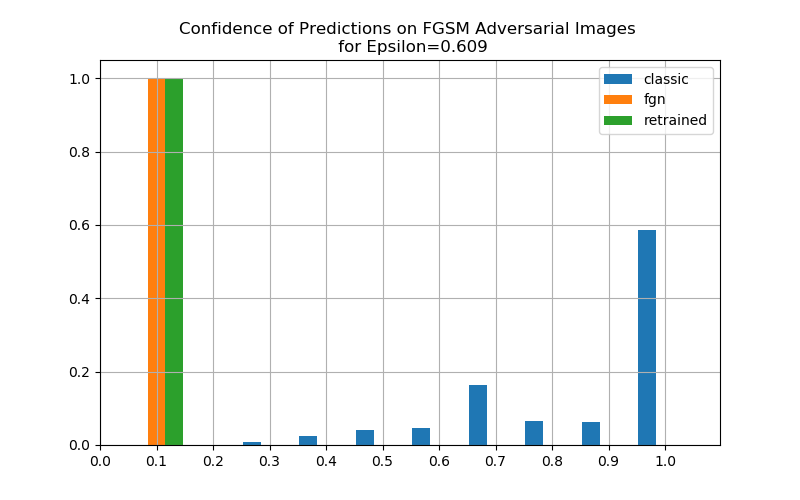

<IPython.core.display.Javascript object>


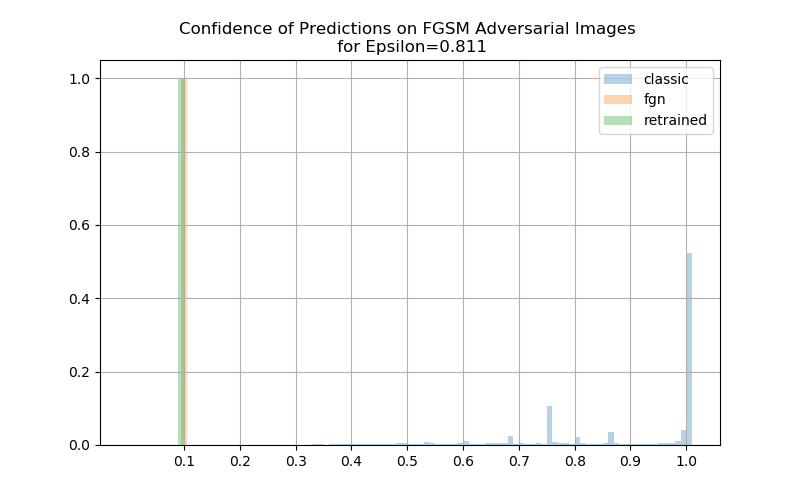

<IPython.core.display.Javascript object>


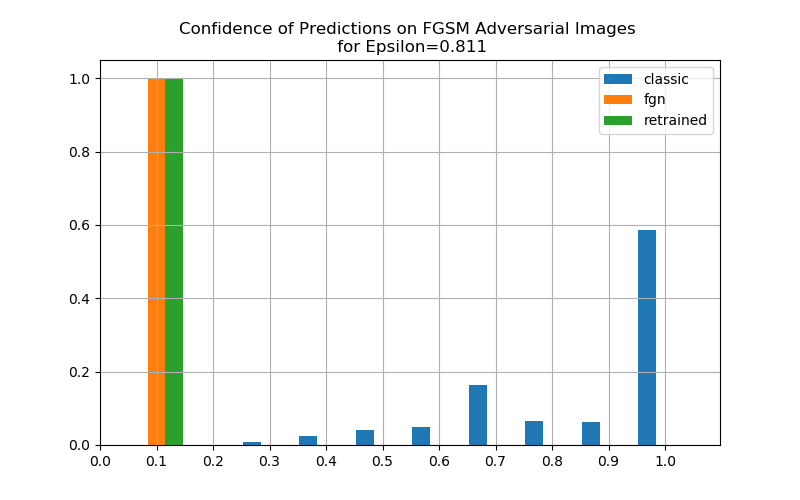

<IPython.core.display.Javascript object>


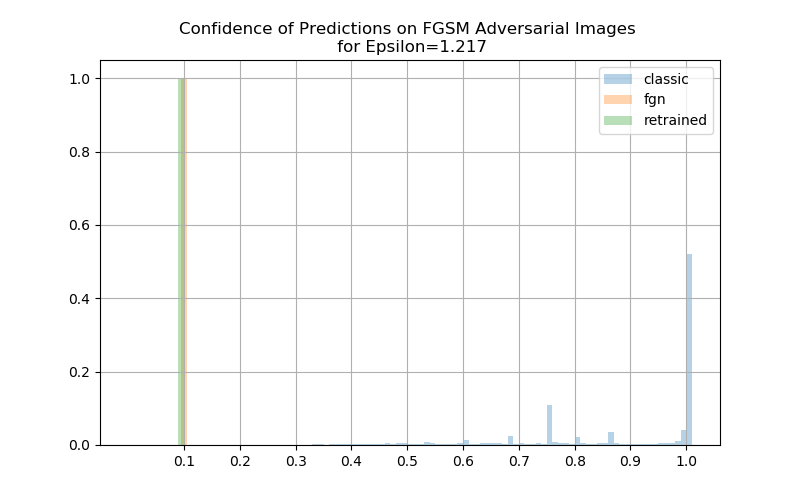

<IPython.core.display.Javascript object>


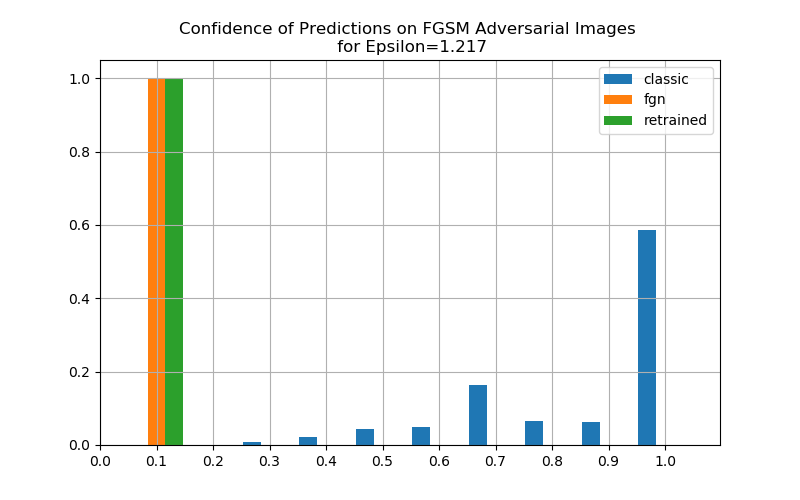

<IPython.core.display.Javascript object>


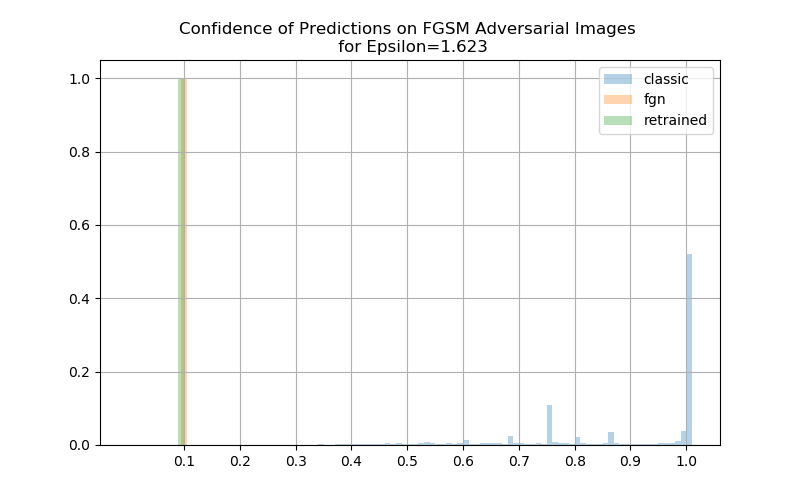

<IPython.core.display.Javascript object>


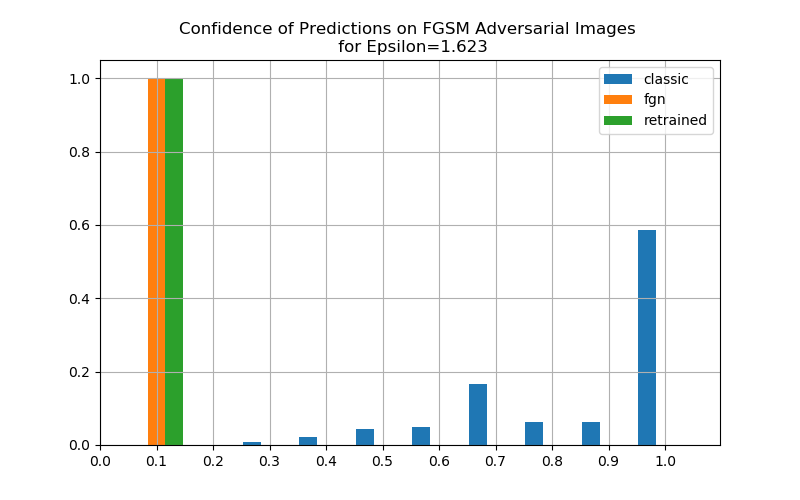

<IPython.core.display.Javascript object>


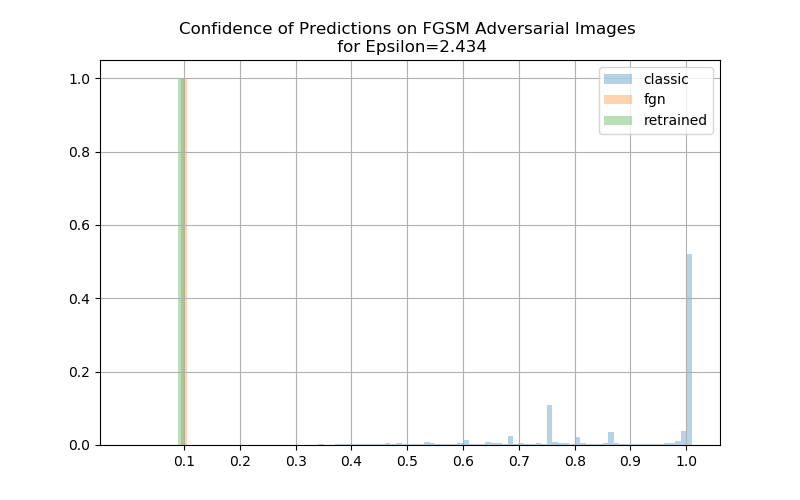

<IPython.core.display.Javascript object>


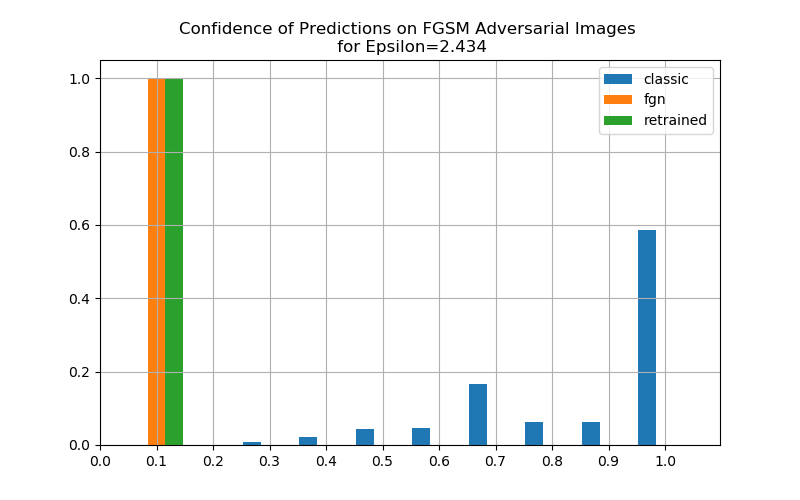

<IPython.core.display.Javascript object>


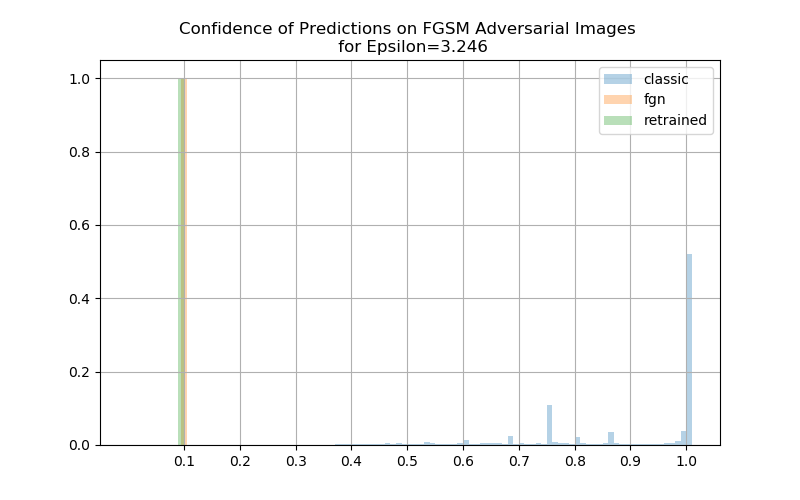

<IPython.core.display.Javascript object>


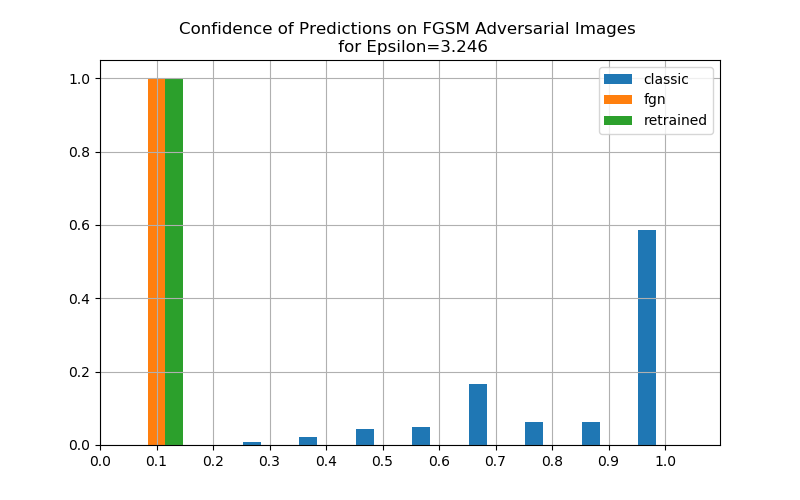

In [46]:
for i, clipped_images in enumerate(zip(classic_clipped, fgn_clipped, ret_fgn_clipped)):
    
    p = [] 
    for n, model in enumerate([classic_model, fgn_model, ret_fgn_model]):
        
        # compute predictions
        model.eval()
        with torch.no_grad(): preds = model(clipped_images[n].to(device))
        preds = preds.cpu().detach().numpy()
        
        # apply softmax for probabilities
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])
        # get the maximums
        preds_maxes = np.max(preds_softmax, axis=1)
        
        p.append(preds_maxes)
        
        # histogram
        plt.hist(preds_maxes,
                 bins=0.005+ np.arange(101)/100,
                 weights=[1/len(preds_maxes) for _ in preds_maxes], 
                 rwidth=1.2,
                 label=names[n],
                 align=al[n], 
                 alpha=0.33)
    plt.xticks((np.arange(10)+1)/10.0)
    plt.legend()
    plt.title('Confidence of Predictions on FGSM Adversarial Images \n for Epsilon={}'.format(np.round(epsilons[i],3)) )
    plt.grid(True)
    plt.show()
        
        
    # histogram
    # weights = np.ones_like(preds_maxes)/len(preds_maxes)
    plt.hist(p, bins= 0.05+ np.arange(11)/10,
             rwidth=0.95, weights=[[1/len(p[0]) for _ in p[0]] for _ in p],
             align='mid',
             label=names )
    plt.xticks(np.arange(11)/10.0)
    plt.legend()
    plt.title('Confidence of Predictions on FGSM Adversarial Images \n for Epsilon={}'.format(np.round(epsilons[i],3)) )
    plt.grid(True)
    plt.show()